In [1]:
import pickle
import os
import sys
import glob
import torch
import numpy as np
import pandas as pd
import scipy.io
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from scipy import signal
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from statistics import mean
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr
from scipy.stats import fisher_exact
from scipy.stats import ranksums
from scipy.stats import pearsonr
from tqdm import tqdm

# jupyter notebook display setting for all data structures
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
np.set_printoptions(threshold=np.inf)

# Data Prep

In [2]:
# load the dictionary of dictionaries from a pickle file
with open('/project2/xinhe/waqaas/DNA-breathing/data/Chipseq_data/seq_breathing_feat.pkl', 'rb') as handle:
    panset = pickle.load(handle)

# load the new feature dictionaries
with open('/project2/xinhe/waqaas/DNA-breathing/data/chipseq_features/compiled_bubble_data/chipseq.pkl', 'rb') as handle:
    features = pickle.load(handle)

In [3]:
# load in the additional dataset
with open('/project2/xinhe/waqaas/DNA-breathing/data/chipseq_features/bubble_data/bubble_data_overall.pkl', 'rb') as handle:
    add_features = pickle.load(handle)

In [4]:
# collapse the train and test partitions into one
data_old = {}
for key in panset.keys():
    tempdata = panset[key]
    for key in tempdata.keys():
        data_old[key] = tempdata[key]

In [5]:
# replace the old feature dictionaries with the new ones
y_slice = 10
z_slice = 6
processed_features = {}
for key in features.keys():
    data = data_old[key]
    feature = features[str(key)]
    # make sure 150 flanks from seq are removed on each side
    # processed_features[key] = {'seq': data['seq'][150:-150], 'label': data['label'], 'bubble': feature['bubbles'][:,y_slice,z_slice]/80000, 'flipping': feature['flip'][:]/80000, 'coords': feature['coord'][:]/80000, 'coordssquared': feature['coord_squared'][:]/80000}
    processed_features[key] = {'seq': data['seq'][150:-150], 'label': data['label'], 'bubble': feature['bubbles'][:,y_slice,z_slice]/80000, 'flipping': data['flip'][150:-150], 'coords': data['coord'][150:-150], 'coordssquared': data['coord_sq'][150:-150]}
for key in add_features.keys():
    data = data_old[key]
    feature = add_features[str(key)]
    # make sure 150 flanks from seq are removed on each side
    processed_features[key] = {'seq': data['seq'][150:-150], 'label': data['label'], 'bubble': feature[:,y_slice,z_slice]/80000, 'flipping': data['flip'][150:-150], 'coords': data['coord'][150:-150], 'coordssquared': data['coord_sq'][150:-150]}

In [6]:
# extract the sequence ids from the data
chipseq_ids = [seq for seq in processed_features.keys()]

# bubble_binary Determination

In [7]:
agnosticset = {}
for seq_id in processed_features.keys():
    agnosticset[seq_id] = processed_features[seq_id]['bubble']

In [8]:
# flatten all the bubble values for each sequence
chipseq_bubble = []
for i in chipseq_ids:
    chipseq_bubble.append(processed_features[i]['bubble'].flatten())
# flatten chipseq_bubble
chipseq_bubble = [item for sublist in chipseq_bubble for item in sublist]
chipseq_bubble = np.array(chipseq_bubble)
chipseq_percentile = np.percentile(chipseq_bubble, 95)

print(chipseq_percentile)

0.000472


In [9]:
arrays = 0
for bubble in agnosticset.keys():
    if np.max(agnosticset[bubble]) > chipseq_percentile:
        arrays += 1

print(f'Total arrays: {len(agnosticset.keys())}')
print(f'Arrays with a maximum value greater than {chipseq_percentile:.4f} at timepoint 0: {arrays}')
print(f'Percentage of arrays with a maximum value greater than {chipseq_percentile:.4f} at timepoint 0: {arrays/len(agnosticset.keys())*100:.2f}%')

Total arrays: 26391
Arrays with a maximum value greater than 0.0005 at timepoint 0: 10359
Percentage of arrays with a maximum value greater than 0.0005 at timepoint 0: 39.25%


In [10]:
for bubble in agnosticset.keys():
    if np.max(agnosticset[bubble]) > chipseq_percentile:
        processed_features[bubble]['bubble_binary'] = 1
    else:
        processed_features[bubble]['bubble_binary'] = 0

now we make dictionaries that will contain the seq_ids(?) and labels for bubble positive and bubble negative data respectively, presumably for statistical analysis

In [11]:
# define path to the TF index
tf_index_file = '/project2/xinhe/waqaas/DNA-breathing/data/Chipseq_data/group_index.pt'
tf_index = torch.load(tf_index_file)
selected_tfs = ['POU2F2', 'CTCF', 'ETS1', 'JUND', 'MAFK', 'EBF1', 'PAX5']

In [12]:
# generate a tf_label component using the index file
for tf in selected_tfs:
    clipboard = []
    indices = tf_index[tf]
    for key in processed_features.keys():
        clipboard.append(processed_features[key]['label'][indices])
    # turn clipboard into a numpy array
    clipboard = np.array(clipboard)
    sums = np.vstack(clipboard)
    sums = sums.sum(axis=0)
    max_index = np.argmax(sums)
    for key in processed_features.keys():
        processed_features[key][tf] = processed_features[key]['label'][indices[max_index]]
# create a tf_label for each entry
for key in processed_features.keys():
    processed_features[key]['tf_label'] = [processed_features[key][tf] for tf in selected_tfs]

In [13]:
tf_label = {}
tf_bubble_binary = {}
for n, name in enumerate(selected_tfs):
    tf_label[name] = []
    tf_bubble_binary[name] = []
    for seq_id in processed_features.keys():
        tf_label[name].append(processed_features[seq_id]['tf_label'][n])
        tf_bubble_binary[name].append(processed_features[seq_id]['bubble_binary'])

In [14]:
# divide the tf_label data into bubble positive and bubble negative data
chipseq_label_bubble_pos = {}
chipseq_label_bubble_neg = {}
for tf in selected_tfs:
    chipseq_label_bubble_pos[tf] = []
    chipseq_label_bubble_neg[tf] = []
    for n, i in enumerate(tf_label[tf]):
        if tf_bubble_binary[tf][n] == 1:
            chipseq_label_bubble_pos[tf].append(i)
        else:
            chipseq_label_bubble_neg[tf].append(i)

In [15]:
# conduct t-tests for each TF to determine if the bubble positive and bubble negative data are significantly different
t_test_results = {}
for tf in selected_tfs:
    t_test_results[tf] = stats.ttest_ind(chipseq_label_bubble_pos[tf], chipseq_label_bubble_neg[tf])

# Use a df to store the t-test results
t_test_df = pd.DataFrame()
t_test_df['TF'] = selected_tfs
t_test_df['t-statistic'] = [t_test_results[tf][0] for tf in selected_tfs]
t_test_df['p-value'] = [t_test_results[tf][1] for tf in selected_tfs]

print(t_test_df.to_markdown())

|    | TF     |   t-statistic |      p-value |
|---:|:-------|--------------:|-------------:|
|  0 | POU2F2 |      -9.29505 | 1.58154e-20  |
|  1 | CTCF   |     -30.9401  | 1.68858e-206 |
|  2 | ETS1   |     -40.4622  | 0            |
|  3 | JUND   |     -11.9923  | 4.75407e-33  |
|  4 | MAFK   |      38.2667  | 0            |
|  5 | EBF1   |       7.60566 | 2.92877e-14  |
|  6 | PAX5   |     -20.3845  | 1.16685e-91  |


In [16]:
# conduct point biserial correlation tests for each TF to determine if the bubble positive and bubble negative data are significantly different
point_biserial_results = {}
for tf in selected_tfs:
    point_biserial_results[tf] = pointbiserialr(tf_bubble_binary[tf], tf_label[tf])

# Use a df to store the point biserial correlation results
point_biserial_df = pd.DataFrame()
point_biserial_df['TF'] = selected_tfs
point_biserial_df['correlation'] = [point_biserial_results[tf][0] for tf in selected_tfs]
point_biserial_df['p-value'] = [point_biserial_results[tf][1] for tf in selected_tfs]

print(point_biserial_df.to_markdown())

|    | TF     |   correlation |      p-value |
|---:|:-------|--------------:|-------------:|
|  0 | POU2F2 |    -0.0571256 | 1.58154e-20  |
|  1 | CTCF   |    -0.187099  | 1.68858e-206 |
|  2 | ETS1   |    -0.241695  | 0            |
|  3 | JUND   |    -0.0736224 | 4.75407e-33  |
|  4 | MAFK   |     0.229288  | 7.28506e-312 |
|  5 | EBF1   |     0.0467682 | 2.92877e-14  |
|  6 | PAX5   |    -0.124508  | 1.16685e-91  |


In [17]:
# conduct chi-squared tests for each TF to determine if the bubble positive and bubble negative data are significantly different
chi_squared_results = {}
for tf in selected_tfs:
    # create contingency table
    contingency_table = pd.crosstab(tf_label[tf], tf_bubble_binary[tf])
    chi_squared_results[tf] = chi2_contingency(contingency_table)

# Use a df to store the chi-squared test results
chi_squared_df = pd.DataFrame()
chi_squared_df['TF'] = selected_tfs
chi_squared_df['chi-squared'] = [chi_squared_results[tf][0] for tf in selected_tfs]
chi_squared_df['p-value'] = [chi_squared_results[tf][1] for tf in selected_tfs]

# remove the index
chi_squared_df.reset_index(drop=True, inplace=True)
# turn the TF column into the index
chi_squared_df.set_index('TF', inplace=True)

print(chi_squared_df.to_markdown())

| TF     |   chi-squared |      p-value |
|:-------|--------------:|-------------:|
| POU2F2 |       85.864  | 1.9275e-20   |
| CTCF   |      923.053  | 9.56182e-203 |
| ETS1   |     1540.41   | 0            |
| JUND   |      142.653  | 6.99953e-33  |
| MAFK   |     1386.07   | 2.2306e-303  |
| EBF1   |       57.5115 | 3.3601e-14   |
| PAX5   |      408.579  | 7.47294e-91  |


# motif_seq Determination

We use the following code to parse HOMER's output into a motif sequence for our dictionary. We will probably replace this as FIMO comes in.

In [18]:
matrix_ids = ['MA0507.2', 'MA1929.1', 'MA0098.3', 'MA0491.2', 'MA0496.3', 'MA0154.4', 'MA0014.3']

In [19]:
# find the fimo results in chipseq_results/{tf}/{matrix_id}/fimo_out/fimo.tsv and create a dictionary of dataframes
fimo_dir = '/project2/xinhe/waqaas/DNA-breathing/src/fasta/chipseq_results'
fimo_dict = {}
for tf, matrix_id in zip(selected_tfs, matrix_ids):
    fimo_dict[tf] = {}
    fimo_file = os.path.join(fimo_dir, tf, matrix_id, 'fimo_out', 'fimo.tsv')
    fimo_dict[tf][matrix_id] = pd.read_csv(fimo_file, sep='\t')

In [20]:
# drop NA values for all dataframes in fimo_dict
for tf in fimo_dict.keys():
    for matrix_id in fimo_dict[tf].keys():
        fimo_dict[tf][matrix_id].dropna(inplace=True)
# turn all the start, stop, sequence_name values in the fimo output dictionary for max into int values using as type int
for tf in fimo_dict.keys():
    for matrix_id in fimo_dict[tf].keys():
        fimo_dict[tf][matrix_id]['sequence_name'] = fimo_dict[tf][matrix_id]['sequence_name'].astype(int)
        fimo_dict[tf][matrix_id]['start'] = fimo_dict[tf][matrix_id]['start'].astype(int)
        fimo_dict[tf][matrix_id]['stop'] = fimo_dict[tf][matrix_id]['stop'].astype(int)
# turn all the sequence_name values in the fimo output dictionary for max into str values using as type str
for tf in fimo_dict.keys():
    for matrix_id in fimo_dict[tf].keys():
        fimo_dict[tf][matrix_id].index = fimo_dict[tf][matrix_id].index.astype(str)
        # sort by sequence_name
        fimo_dict[tf][matrix_id].sort_values(by=['sequence_name'], inplace=True)
        # turn sequence_name into index
        #fimo_dict[tf][matrix_id].set_index('sequence_name', inplace=True)

In [21]:
# convert processed_features into a dataframe
processed_features_df = pd.DataFrame.from_dict(processed_features, orient='index')

In [22]:
processed_features_df.head()

,seq,label,bubble,flipping,coords,coordssquared,bubble_binary,POU2F2,CTCF,ETS1,JUND,MAFK,EBF1,PAX5,tf_label
84336,GACGGGTTCTGGACGGTTTACAGAGGCTGTGCACTTGACTGCCTTT...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[2.2e-05, 3.7875e-05, 5.45e-05, 7.25e-05, 8.67...","[0.0628, 0.0734, 0.0489, 0.0468, 0.0562, 0.062...","[0.1578, 0.2005, 0.14, 0.1364, 0.1482, 0.159, ...","[0.119, 0.1437, 0.0965, 0.0936, 0.1086, 0.1216...",1,1,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0]"
822913,TCACACCCCTTGCTGACTCAGCCTTTGTACTGTGTTCTCTGCCTTG...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3.775e-05, 3.5249999999999996e-05, 3.52499999...","[0.0781, 0.0645, 0.0706, 0.0596, 0.0688, 0.058...","[0.208, 0.1623, 0.1982, 0.1555, 0.1956, 0.1523...","[0.1543, 0.1235, 0.1415, 0.1135, 0.1373, 0.111...",0,0,0,0,0,1,0,0,"[0, 0, 0, 0, 1, 0, 0]"
914995,TTCCTGGATGTGTAGTGATTCATGGGACATTGCCCTGACCTCATTC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.00027875, 0.000262, 0.000266875, 0.00025049...","[0.1014, 0.0957, 0.0698, 0.0615, 0.0692, 0.059...","[0.2442, 0.2346, 0.1689, 0.1578, 0.1973, 0.155...","[0.2007, 0.1904, 0.1377, 0.1217, 0.1421, 0.118...",1,0,0,0,0,1,0,0,"[0, 0, 0, 0, 1, 0, 0]"
756501,TGGAAGCTCTCGAGGGAGAGAGGGCGAAGGGAGGAGCTTACGGGTG...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[4.5e-05, 4.1375e-05, 4.875e-05, 6.6375e-05, 5...","[0.082, 0.0643, 0.0696, 0.089, 0.081, 0.0557, ...","[0.2169, 0.1625, 0.1685, 0.2242, 0.2144, 0.150...","[0.1667, 0.1297, 0.1368, 0.1737, 0.1606, 0.111...",0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 1, 0]"
1031172,CGCATCTTTAGTTTTCTAGGGACAATGATAATTGGATGTGCAAGAT...,"[0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, ...","[5.6875e-05, 6.4125e-05, 6.6625e-05, 7.6624999...","[0.0371, 0.0378, 0.0483, 0.0753, 0.0887, 0.075...","[0.1226, 0.124, 0.1394, 0.2064, 0.2239, 0.1784...","[0.0759, 0.0779, 0.0947, 0.149, 0.1737, 0.1506...",0,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"


In [23]:
tf_counts = {}
for n, tf in enumerate(selected_tfs):
    tf_counts[tf] = 0
    for seq_id in processed_features.keys():
        if processed_features[seq_id]['tf_label'][n] == 1:
            tf_counts[tf] += 1

print(tf_counts)

{'POU2F2': 7561, 'CTCF': 9613, 'ETS1': 5070, 'JUND': 4728, 'MAFK': 3500, 'EBF1': 7461, 'PAX5': 8860}


In [24]:
# stat summary of fimo_dict['POU2F2']['MA0507.2']['p-value']
fimo_dict['POU2F2']['MA0507.2']['p-value'].describe()

count    3.416080e+05
mean     4.828566e-04
std      2.957283e-04
min      7.660000e-09
25%      2.200000e-04
50%      4.820000e-04
75%      7.400000e-04
max      9.980000e-04
Name: p-value, dtype: float64

In [25]:
for n, tf in enumerate(selected_tfs):
    for matrix_id in tqdm(fimo_dict[tf].keys(), desc=f'Processing matrix ids for {tf}'):
        df_motif = fimo_dict[tf][matrix_id].copy()
        # create 'coord', 'coord_sq', 'flip' and 'label' columns in fimo_dict[tf][matrix_id]
        fimo_dict[tf][matrix_id][["coords","coordssquared","flipping","label"]] = None
        # take the df corresponding to fimo_dict['tf']['matrix_id'] and iterate over the rows
        for row in tqdm(df_motif.itertuples(), desc=f'Processing rows for {tf}_{matrix_id}'):
            # get the index
            index = row.Index
            # get the sequence name
            seq_id = str(row.sequence_name)
            # get the strand
            strand = row.strand
            # get the start and stop
            start = int(row.start)
            stop = int(row.stop)
            # make sure seq_id is in processed_features_df's index
            if seq_id not in processed_features_df.index:
                continue
            else:
                # if strand is positive
                if strand == '+':
                    # get the coord, coord_sq and flip values from the start to stop indices and add them to the fimo_dict dataframe
                    coords = processed_features_df.at[seq_id, 'coords']
                    fimo_dict[tf][matrix_id].at[index, 'coords'] = coords[start:stop]
                    coordssquared = processed_features_df.at[seq_id, 'coordssquared']
                    fimo_dict[tf][matrix_id].at[index, 'coordssquared'] = coordssquared[start:stop]
                    flipping = processed_features_df.at[seq_id, 'flipping']
                    fimo_dict[tf][matrix_id].at[index, 'flipping'] = flipping[start:stop]
                # if strand is negative
                elif strand == '-':
                    # get the coord, coord_sq and flip values from the start to stop indices and add them to the fimo_dict dataframe
                    coords = processed_features_df.at[seq_id, 'coords']
                    fimo_dict[tf][matrix_id].at[index, 'coords'] = coords[start:stop][::-1]
                    coordssquared = processed_features_df.at[seq_id, 'coordssquared']
                    fimo_dict[tf][matrix_id].at[index, 'coordssquared'] = coordssquared[start:stop][::-1]
                    flipping = processed_features_df.at[seq_id, 'flipping']
                    fimo_dict[tf][matrix_id].at[index, 'flipping'] = flipping[start:stop][::-1]
                # the key in group index is the tf and the value is a list of indices in the label column of df that correspond to the tf
                # take the list of indices in the label column of df that correspond to the tf indices in group_index and add this list to the fimo_dict dataframe
                label = processed_features_df.at[seq_id, 'tf_label'][n]
                fimo_dict[tf][matrix_id].at[index, 'label'] = label
        #         break
        #     break
        # break

Processing matrix ids for POU2F2:   0%|          | 0/1 [00:00<?, ?it/s]
Processing rows for POU2F2_MA0507.2: 0it [00:00, ?it/s]
Processing rows for POU2F2_MA0507.2: 1448it [00:00, 14478.46it/s]
Processing rows for POU2F2_MA0507.2: 8228it [00:00, 45839.25it/s]
Processing rows for POU2F2_MA0507.2: 15305it [00:00, 57216.47it/s]
Processing rows for POU2F2_MA0507.2: 23309it [00:00, 66209.97it/s]
Processing rows for POU2F2_MA0507.2: 37658it [00:00, 94061.90it/s]
Processing rows for POU2F2_MA0507.2: 61458it [00:00, 142988.60it/s]
Processing rows for POU2F2_MA0507.2: 89397it [00:00, 187571.18it/s]
Processing rows for POU2F2_MA0507.2: 118356it [00:00, 220040.89it/s]
Processing rows for POU2F2_MA0507.2: 147031it [00:00, 240889.15it/s]
Processing rows for POU2F2_MA0507.2: 174751it [00:01, 252094.00it/s]
Processing rows for POU2F2_MA0507.2: 204942it [00:01, 267336.24it/s]
Processing rows for POU2F2_MA0507.2: 234365it [00:01, 275512.66it/s]
Processing rows for POU2F2_MA0507.2: 264189it [00:01, 2823

changing this to have a p-value seq and a motif counter seq

In [26]:
# Initialize arrays only once per TF/Matrix ID
seq_len = 200
for tf, matrix_id in zip(selected_tfs, matrix_ids):
    overlap = 0
    non_overlap = 0
    both_zero = 0
    for seq_id in tqdm(processed_features.keys()):
        # Use vectorized NumPy operations to initialize arrays instead of explicit loops
        zeros_array = np.zeros(seq_len)
        processed_features[seq_id][tf] = {
            'motif_seq_positive': zeros_array.copy(),
            'motif_seq_negative': zeros_array.copy(),
            'motif_seq': zeros_array.copy(),
            'p-value_positive': zeros_array.copy(),
            'p-value_negative': zeros_array.copy(),
            'p-value_seq': zeros_array.copy(),
            'motif_seq_counter_positive': zeros_array.copy(),
            'motif_seq_counter_negative': zeros_array.copy(),
        }
        
        # Get the indices of the rows in fimo_dict[tf][matrix_id] for this sequence_id
        seq_indices = fimo_dict[tf][matrix_id].loc[fimo_dict[tf][matrix_id]['sequence_name'] == int(seq_id)].index

        for idx in seq_indices:
            start, stop = fimo_dict[tf][matrix_id].at[idx, 'start'], fimo_dict[tf][matrix_id].at[idx, 'stop']
            
            if fimo_dict[tf][matrix_id].at[idx, 'strand'] == '+':
                processed_features[seq_id][tf]['motif_seq_positive'][start:stop] = 1
                processed_features[seq_id][tf]['p-value_positive'][start:stop] = fimo_dict[tf][matrix_id].at[idx, 'p-value']
                processed_features[seq_id][tf]['motif_seq_counter_positive'][start:stop] = idx
            else:
                processed_features[seq_id][tf]['motif_seq_negative'][start:stop] = 1
                processed_features[seq_id][tf]['p-value_negative'][start:stop] = fimo_dict[tf][matrix_id].at[idx, 'p-value']
                processed_features[seq_id][tf]['motif_seq_counter_negative'][start:stop] = idx

        # Fill 'motif_seq' with the union of positive and negative strand
        processed_features[seq_id][tf]['motif_seq'] = np.maximum(
            processed_features[seq_id][tf]['motif_seq_positive'], 
            processed_features[seq_id][tf]['motif_seq_negative']
        )

        # Set 'p-value_seq' to the maximum p-value of positive and negative strands
        processed_features[seq_id][tf]['p-value_seq'] = np.maximum(
            processed_features[seq_id][tf]['p-value_positive'], 
            processed_features[seq_id][tf]['p-value_negative']
        )

        positive_counter = processed_features[seq_id][tf]['motif_seq_counter_positive']
        negative_counter = processed_features[seq_id][tf]['motif_seq_counter_negative']

        # Identify overlap where both positive and negative counters are non-zero
        overlaps = (positive_counter != 0) & (negative_counter != 0)
        overlap += np.sum(overlaps)

        # Identify non-overlap where only one counter is non-zero
        non_overlaps = (positive_counter != 0) ^ (negative_counter != 0)
        non_overlap += np.sum(non_overlaps)

        # Identify places where both counters are zero
        both_zeros = (positive_counter == 0) & (negative_counter == 0)
        both_zero += np.sum(both_zeros)

    print(f'Overlap for {tf}: {overlap}')
    print(f'Non-overlap for {tf}: {non_overlap}')
    print(f'Both Zeros for {tf}: {both_zero}')

100%|██████████| 26391/26391 [00:11<00:00, 2207.07it/s]


Overlap for POU2F2: 2727
Non-overlap for POU2F2: 80721
Both Zeros for POU2F2: 5194752


100%|██████████| 26391/26391 [00:07<00:00, 3365.98it/s]


Overlap for CTCF: 24098
Non-overlap for CTCF: 301263
Both Zeros for CTCF: 4952839


100%|██████████| 26391/26391 [00:11<00:00, 2367.74it/s]


Overlap for ETS1: 494
Non-overlap for ETS1: 141653
Both Zeros for ETS1: 5136053


100%|██████████| 26391/26391 [00:07<00:00, 3407.91it/s]


Overlap for JUND: 45389
Non-overlap for JUND: 19904
Both Zeros for JUND: 5212907


100%|██████████| 26391/26391 [00:08<00:00, 3111.42it/s]


Overlap for MAFK: 33158
Non-overlap for MAFK: 98907
Both Zeros for MAFK: 5146135


100%|██████████| 26391/26391 [00:08<00:00, 3263.43it/s]


Overlap for EBF1: 45258
Non-overlap for EBF1: 50589
Both Zeros for EBF1: 5182353


100%|██████████| 26391/26391 [00:09<00:00, 2783.01it/s]

Overlap for PAX5: 3901
Non-overlap for PAX5: 205615
Both Zeros for PAX5: 5068684


In [27]:
for tf, matrix_id in zip(selected_tfs, matrix_ids):
    no_motif = 0
    strong_motifs = 0
    weak_motifs = 0
    weak_and_strong_motifs = 0
    
    for seq_id in processed_features.keys():
        # Initialize the binary attributes to zero
        processed_features[seq_id][tf]['strong_motif_binary'] = 0
        processed_features[seq_id][tf]['weak_motif_binary'] = 0
        
        # Extract p-values for ease of access
        p_positive = processed_features[seq_id][tf]['p-value_positive']
        p_negative = processed_features[seq_id][tf]['p-value_negative']
        
        # Check if there's any p-value
        if max(p_positive) == 0 and max(p_negative) == 0:
            no_motif += 1
        
        # Check for strong motifs
        if any((0 < p <= 0.0001 for p in p_positive)) or any((0 < p <= 0.0001 for p in p_negative)):
            processed_features[seq_id][tf]['strong_motif_binary'] = 1
            strong_motifs += 1
        
        # Check for weak motifs
        if any((p > 0.0001 for p in p_positive)) or any((p > 0.0001 for p in p_negative)):
            processed_features[seq_id][tf]['weak_motif_binary'] = 1
            weak_motifs += 1
        
        # Determine if both strong and weak motifs are present
        if processed_features[seq_id][tf]['strong_motif_binary'] == 1 and processed_features[seq_id][tf]['weak_motif_binary'] == 1:
            weak_and_strong_motifs += 1
            
    print(f'{tf} strong motifs: {strong_motifs}')
    print(f'{tf} weak motifs: {weak_motifs}')
    print(f'{tf} strong and weak motifs: {weak_and_strong_motifs}')
    print(f'{tf} no motifs: {no_motif}')


POU2F2 strong motifs: 1115
POU2F2 weak motifs: 4397
POU2F2 strong and weak motifs: 385
POU2F2 no motifs: 21264
CTCF strong motifs: 5954
CTCF weak motifs: 2901
CTCF strong and weak motifs: 1227
CTCF no motifs: 18763
ETS1 strong motifs: 2390
ETS1 weak motifs: 10259
ETS1 strong and weak motifs: 1088
ETS1 no motifs: 14830
JUND strong motifs: 2947
JUND weak motifs: 3322
JUND strong and weak motifs: 1475
JUND no motifs: 21597
MAFK strong motifs: 3445
MAFK weak motifs: 5633
MAFK strong and weak motifs: 1419
MAFK no motifs: 18732
EBF1 strong motifs: 4201
EBF1 weak motifs: 3053
EBF1 strong and weak motifs: 1487
EBF1 no motifs: 20624
PAX5 strong motifs: 1952
PAX5 weak motifs: 11271
PAX5 strong and weak motifs: 1138
PAX5 no motifs: 14306


In [84]:
# use a df to store the tf_label, bubble_binary, strong_motif_binary and weak_motif_binary counts
tf_stats = pd.DataFrame(index=selected_tfs)

for tf in selected_tfs:
    tf_stats.at[tf, 'Positive Labels'] = tf_counts[tf]
    tf_stats.at[tf, 'Negative Labels'] = 26391 - tf_counts[tf]
    tf_stats.at[tf, 'Sequences with Bubbles'] = sum([processed_features[seq_id]['bubble_binary'] for seq_id in processed_features])
    tf_stats.at[tf, 'Sequences with Strong Motifs'] = 0
    tf_stats.at[tf, 'Sequences with Weak Motifs'] = 0
    tf_stats.at[tf, 'Sequences with Strong and Weak Motifs'] = 0
    for seq_id in processed_features.keys():
        tf_stats.at[tf, 'Sequences with Strong Motifs'] += processed_features[seq_id][tf]['strong_motif_binary']
        tf_stats.at[tf, 'Sequences with Weak Motifs'] += processed_features[seq_id][tf]['weak_motif_binary']
        if processed_features[seq_id][tf]['strong_motif_binary'] == 1 and processed_features[seq_id][tf]['weak_motif_binary'] == 1:
            tf_stats.at[tf, 'Sequences with Strong and Weak Motifs'] += 1

tf_stats

,Positive Labels,Negative Labels,Sequences with Bubbles,Sequences with Strong Motifs,Sequences with Weak Motifs,Sequences with Strong and Weak Motifs
POU2F2,7561.0,18830.0,10359.0,1115.0,4397.0,385.0
CTCF,9613.0,16778.0,10359.0,5954.0,2901.0,1227.0
ETS1,5070.0,21321.0,10359.0,2390.0,10259.0,1088.0
JUND,4728.0,21663.0,10359.0,2947.0,3322.0,1475.0
MAFK,3500.0,22891.0,10359.0,3445.0,5633.0,1419.0
EBF1,7461.0,18930.0,10359.0,4201.0,3053.0,1487.0
PAX5,8860.0,17531.0,10359.0,1952.0,11271.0,1138.0


In [85]:
print(tf_stats.to_markdown())

|        |   Positive Labels |   Negative Labels |   Sequences with Bubbles |   Sequences with Strong Motifs |   Sequences with Weak Motifs |   Sequences with Strong and Weak Motifs |
|:-------|------------------:|------------------:|-------------------------:|-------------------------------:|-----------------------------:|----------------------------------------:|
| POU2F2 |              7561 |             18830 |                    10359 |                           1115 |                         4397 |                                     385 |
| CTCF   |              9613 |             16778 |                    10359 |                           5954 |                         2901 |                                    1227 |
| ETS1   |              5070 |             21321 |                    10359 |                           2390 |                        10259 |                                    1088 |
| JUND   |              4728 |             21663 |                    10359 |   

In [30]:
# counts of positive, negative, strong, and weak motifs as well as the total number of motifs per tf
for tf, matrix_id in zip(selected_tfs, matrix_ids):
    positive_motifs = 0
    negative_motifs = 0
    strong_motifs = 0
    weak_motifs = 0
    total_motifs = 0
    total_sequences = 0
    for seq_id in processed_features.keys():
        total_sequences += 1
        if sum(processed_features[seq_id][tf]['motif_seq_positive']) != 0:
            positive_motifs += 1
        if sum(processed_features[seq_id][tf]['motif_seq_negative']) != 0:
            negative_motifs += 1
        strong_motifs += processed_features[seq_id][tf]['strong_motif_binary']
        weak_motifs += processed_features[seq_id][tf]['weak_motif_binary']
        if sum(processed_features[seq_id][tf]['motif_seq_positive']) != 0 or sum(processed_features[seq_id][tf]['motif_seq_negative']) != 0:
            total_motifs += 1
    print(tf)
    print(f'positive motifs: {positive_motifs}')
    print(f'negative motifs: {negative_motifs}')
    print(f'strong motifs: {strong_motifs}')
    print(f'weak motifs: {weak_motifs}')
    print(f'total motifs: {total_motifs}')
    print(f'total sequences: {total_sequences}')

POU2F2
positive motifs: 2991
negative motifs: 2878
strong motifs: 1115
weak motifs: 4397
total motifs: 5127
total sequences: 26391
CTCF
positive motifs: 4677
negative motifs: 4519
strong motifs: 5954
weak motifs: 2901
total motifs: 7628
total sequences: 26391
ETS1
positive motifs: 6671
negative motifs: 6626
strong motifs: 2390
weak motifs: 10259
total motifs: 11561
total sequences: 26391
JUND
positive motifs: 4147
negative motifs: 4144
strong motifs: 2947
weak motifs: 3322
total motifs: 4794
total sequences: 26391
MAFK
positive motifs: 5319
negative motifs: 5243
strong motifs: 3445
weak motifs: 5633
total motifs: 7659
total sequences: 26391
EBF1
positive motifs: 4432
negative motifs: 4415
strong motifs: 4201
weak motifs: 3053
total motifs: 5767
total sequences: 26391
PAX5
positive motifs: 7546
negative motifs: 7505
strong motifs: 1952
weak motifs: 11271
total motifs: 12085
total sequences: 26391


# bubble_seq Determination

In [31]:
# use the percentile threshold to create a binary array of bubble values for each sequence
for seq_id in tqdm(processed_features.keys()):
    processed_features[seq_id]['bubble_seq'] = np.zeros(len(processed_features[seq_id]['seq']))
    for i in range(len(processed_features[seq_id]['bubble'])):
        if processed_features[seq_id]['bubble'][i] > chipseq_percentile:
            processed_features[seq_id]['bubble_seq'][i] = 1

100%|██████████| 26391/26391 [00:01<00:00, 21618.51it/s]


In [32]:
# bubble count
for seq_id in tqdm(processed_features.keys()):
    processed_features[seq_id]['bubble_count'] = 0
    # we treat each cluster of 1s as a single bubble
    flipper = 0
    for i in range(len(processed_features[seq_id]['bubble_seq'])):
        if flipper == 0:
            if processed_features[seq_id]['bubble_seq'][i] == 1:
                flipper = 1
                processed_features[seq_id]['bubble_count'] += 1
            elif processed_features[seq_id]['bubble_seq'][i] == 0:
                continue
        elif flipper == 1:
            if processed_features[seq_id]['bubble_seq'][i] == 1:
                continue
            elif processed_features[seq_id]['bubble_seq'][i] == 0:
                flipper = 0

# motif count
    # use max on motif_counters to get the number of motifs
    for tf in selected_tfs:
        processed_features[seq_id][tf]['motif_count'] = processed_features[seq_id][tf]['motif_seq_counter_positive'].max() + processed_features[seq_id][tf]['motif_seq_counter_negative'].max()
        
        # strong motif count and weak motif count
        # first we get set of unique values of p_values
        p_values = set(processed_features[seq_id][tf]['p-value_positive']) | set(processed_features[seq_id][tf]['p-value_negative'])
        processed_features[seq_id][tf]['strong_motif_count'] = 0
        for p_value in p_values:
            if 0 < p_value <= 0.0001:
                processed_features[seq_id][tf]['strong_motif_count'] += 1
        processed_features[seq_id][tf]['weak_motif_count'] = 0
        for p_value in p_values:
            if p_value > 0.0001:
                processed_features[seq_id][tf]['weak_motif_count'] += 1

100%|██████████| 26391/26391 [00:09<00:00, 2667.17it/s]


# motif_binary and motif_and_bubble_binary Determination

In [33]:
for tf in selected_tfs:
    for seq_id in processed_features.keys():
        processed_features[seq_id][tf]['strong_motif_and_bubble_binary'] = 0
        processed_features[seq_id][tf]['weak_motif_and_bubble_binary'] = 0
        processed_features[seq_id][tf]['motif_and_bubble_binary'] = 0
        if processed_features[seq_id][tf]['strong_motif_binary'] == 1 and processed_features[seq_id]['bubble_binary'] == 1:
            processed_features[seq_id][tf]['motif_and_bubble_binary'] = 1
            processed_features[seq_id][tf]['strong_motif_and_bubble_binary'] = 1
        elif processed_features[seq_id][tf]['weak_motif_binary'] == 1 and processed_features[seq_id]['bubble_binary'] == 1:
            processed_features[seq_id][tf]['motif_and_bubble_binary'] = 1
            processed_features[seq_id][tf]['weak_motif_and_bubble_binary'] = 1

Now we try to do the Fischer test

In [34]:
affinity = {}
for n, tf in enumerate(selected_tfs):
    affinity[tf] = {}
    for seq_id in processed_features.keys():
        affinity[tf][seq_id] = processed_features[seq_id]['tf_label'][n]

# # only taking positive sequences
# affinity = {}
# for n, tf in enumerate(selected_tfs):
#     affinity[tf] = {}
#     for seq_id in processed_features.keys():
#         if processed_features[seq_id]['tf_label'][n] == 1:
#             affinity[tf][seq_id] = processed_features[seq_id]['tf_label'][n]

# keep only the seq_ids in affinity that have the top 20% binding affinity

# Calculate the 20th percentile of binding affinity for each TF and part
# percentile_cutoff = 20
# for tf in affinity.keys():
#     seq_ids = list(affinity[tf].keys())
#     binding_affinities = [affinity[tf][seq_id] for seq_id in seq_ids]
#     cutoff_value = np.percentile(binding_affinities, 100 - percentile_cutoff)

#     # Keep only the seq_ids in affinity that have the top 20% binding affinity
#     top_20_seq_ids = [seq_id for seq_id in seq_ids if affinity[tf][seq_id] >= cutoff_value]
#     affinity[tf] = {seq_id: affinity[tf][seq_id] for seq_id in top_20_seq_ids}

In [35]:
fischer = {}

for tf in selected_tfs:
    fischer[tf] = {}
    L = 0
    B = 0
    M = 0
    x = 0
    for seq_id in affinity[tf].keys():
        if seq_id in processed_features.keys():
            L += 200
            if processed_features[seq_id]['bubble_binary'] == 0:
                for i in range(200):
                    if processed_features[seq_id][tf]['strong_motif_binary'] == 1 and (processed_features[seq_id][tf]['motif_seq_positive'][i] == 1 or processed_features[seq_id][tf]['motif_seq_negative'][i] == 1):
                        M += 1
            else:
                for i in range(200):
                    if processed_features[seq_id]['bubble_seq'][i] == 1:
                        B += 1
                    if processed_features[seq_id][tf]['strong_motif_binary'] == 1 and (processed_features[seq_id][tf]['motif_seq_positive'][i] == 1 or processed_features[seq_id][tf]['motif_seq_negative'][i] == 1):
                        M += 1
                    if processed_features[seq_id][tf]['strong_motif_binary'] == 1 and (processed_features[seq_id]['bubble_seq'][i] == 1 and (processed_features[seq_id][tf]['motif_seq_positive'][i] == 1 or processed_features[seq_id][tf]['motif_seq_negative'][i] == 1)):
                        x += 1
    fischer[tf]['L'] = L
    fischer[tf]['B'] = B
    fischer[tf]['M'] = M
    fischer[tf]['x'] = x
                

In [36]:
fischer

{'POU2F2': {'L': 5278200, 'B': 263784, 'M': 21153, 'x': 3958},
 'CTCF': {'L': 5278200, 'B': 263784, 'M': 266429, 'x': 853},
 'ETS1': {'L': 5278200, 'B': 263784, 'M': 36945, 'x': 494},
 'JUND': {'L': 5278200, 'B': 263784, 'M': 41467, 'x': 2279},
 'MAFK': {'L': 5278200, 'B': 263784, 'M': 65647, 'x': 2122},
 'EBF1': {'L': 5278200, 'B': 263784, 'M': 72718, 'x': 725},
 'PAX5': {'L': 5278200, 'B': 263784, 'M': 42576, 'x': 93}}

In [89]:
# turn fischer into a dataframe
fischer_df = pd.DataFrame.from_dict(fischer, orient='index')
print(fischer_df.to_markdown())

|        |          L |      B |      M |    x |
|:-------|-----------:|-------:|-------:|-----:|
| POU2F2 | 5.2782e+06 | 263784 |  21153 | 3958 |
| CTCF   | 5.2782e+06 | 263784 | 266429 |  853 |
| ETS1   | 5.2782e+06 | 263784 |  36945 |  494 |
| JUND   | 5.2782e+06 | 263784 |  41467 | 2279 |
| MAFK   | 5.2782e+06 | 263784 |  65647 | 2122 |
| EBF1   | 5.2782e+06 | 263784 |  72718 |  725 |
| PAX5   | 5.2782e+06 | 263784 |  42576 |   93 |


In [38]:
def conduct_fisher_test(fischer_scores):
    scores = {}
    for tf, data in fischer_scores.items():
        L = data['L']
        B = data['B']
        M = data['M']
        x = data['x']

        # Contingency table
        contingency_table = [[x, M - x], [B - x, L - M - B + x]]

        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact(contingency_table)
        scores[tf] = {'odds_ratio': odds_ratio, 'p_value': p_value}

        # Print results
        print(f"TF: {tf}")
        print(f"Contingency Table:")
        print(f"         | Bubble+ | Bubble-")
        print(f"Motif+   |   {x}   |   {M - x}")
        print(f"Motif-   |   {B - x}   |   {L - M - B + x}")
        print(f"Odds Ratio: {odds_ratio}")
        print(f"P-value: {p_value}\n")

    return scores

In [39]:
fischer_scores = conduct_fisher_test(fischer)

TF: POU2F2
Contingency Table:
         | Bubble+ | Bubble-
Motif+   |   3958   |   17195
Motif-   |   259826   |   4997221
Odds Ratio: 4.427102310200854
P-value: 0.0

TF: CTCF
Contingency Table:
         | Bubble+ | Bubble-
Motif+   |   853   |   265576
Motif-   |   262931   |   4748840
Odds Ratio: 0.05801041200452795
P-value: 0.0

TF: ETS1
Contingency Table:
         | Bubble+ | Bubble-
Motif+   |   494   |   36451
Motif-   |   263290   |   4977965
Odds Ratio: 0.2562329495619673
P-value: 0.0

TF: JUND
Contingency Table:
         | Bubble+ | Bubble-
Motif+   |   2279   |   39188
Motif-   |   261505   |   4975228
Odds Ratio: 1.1064306978478666
P-value: 4.117707244047509e-06

TF: MAFK
Contingency Table:
         | Bubble+ | Bubble-
Motif+   |   2122   |   63525
Motif-   |   261662   |   4950891
Odds Ratio: 0.6320383260371489
P-value: 1.5773019357899854e-109

TF: EBF1
Contingency Table:
         | Bubble+ | Bubble-
Motif+   |   725   |   71993
Motif-   |   263059   |   4942423
Odds Ratio:

In [86]:
# Use a df to store the fischer test results
fischer_df_scores = pd.DataFrame.from_dict(fischer_scores, orient='index')
print(fischer_df_scores.to_markdown())

|        |   odds_ratio |     p_value |
|:-------|-------------:|------------:|
| POU2F2 |    4.4271    | 0           |
| CTCF   |    0.0580104 | 0           |
| ETS1   |    0.256233  | 0           |
| JUND   |    1.10643   | 4.11771e-06 |
| MAFK   |    0.632038  | 1.5773e-109 |
| EBF1   |    0.189206  | 0           |
| PAX5   |    0.041276  | 0           |


In [90]:
# left join fischer_df_scores with fisher_df
fischer_df = fischer_df.join(fischer_df_scores, how='left')
print(fischer_df.to_markdown())

|        |          L |      B |      M |    x |   odds_ratio |     p_value |
|:-------|-----------:|-------:|-------:|-----:|-------------:|------------:|
| POU2F2 | 5.2782e+06 | 263784 |  21153 | 3958 |    4.4271    | 0           |
| CTCF   | 5.2782e+06 | 263784 | 266429 |  853 |    0.0580104 | 0           |
| ETS1   | 5.2782e+06 | 263784 |  36945 |  494 |    0.256233  | 0           |
| JUND   | 5.2782e+06 | 263784 |  41467 | 2279 |    1.10643   | 4.11771e-06 |
| MAFK   | 5.2782e+06 | 263784 |  65647 | 2122 |    0.632038  | 1.5773e-109 |
| EBF1   | 5.2782e+06 | 263784 |  72718 |  725 |    0.189206  | 0           |
| PAX5   | 5.2782e+06 | 263784 |  42576 |   93 |    0.041276  | 0           |


Now we perform the linear test

In [41]:
import statsmodels.api as sm

def perform_logistic_regression(data, x_columns, y_column):
    X = data[x_columns]
    y = data[y_column]

    # this is binary logistic regression
    logit_model = sm.Logit(y, X)
    result = logit_model.fit()

    return result

In [42]:
models = {}

for n, tf in enumerate(selected_tfs):
    data[tf] = []
    for seq_id in affinity[tf].keys():
        if seq_id in processed_features.keys():
            data_point = {
                'motif_binary': processed_features[seq_id][tf]['strong_motif_binary'],
                'bubble_binary': processed_features[seq_id]['bubble_binary'],
                'motif_and_bubble_binary': processed_features[seq_id][tf]['strong_motif_and_bubble_binary'],
                'binding_affinity': processed_features[seq_id]['tf_label'][n]
            }
            # Append the data point to the appropriate list based on the presence of motif and bubble
            data[tf].append(data_point)

    # Create pandas DataFrame for each TF
    df = pd.DataFrame(data[tf])

    # Perform linear regression for each case
    model_motif = perform_logistic_regression(df, ['motif_binary'], 'binding_affinity')
    model_bubble = perform_logistic_regression(df, ['bubble_binary'], 'binding_affinity')
    model_double = perform_logistic_regression(df, ['motif_binary', 'bubble_binary'], 'binding_affinity')
    model_triple = perform_logistic_regression(df, ['motif_binary', 'bubble_binary', 'motif_and_bubble_binary'], 'binding_affinity')

    # Store the models for each TF
    models[tf] = {
        'motif_only': model_motif,
        'bubble_only': model_bubble,
        'both_features': model_double,
        'all_features': model_triple
    }

Optimization terminated successfully.
         Current function value: 0.677507
         Iterations 4
Optimization terminated successfully.
         Current function value: 80.820962
         Iterations 5
Optimization terminated successfully.
         Current function value: 83.954616
         Iterations 5
Optimization terminated successfully.
         Current function value: 84.212957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614569
         Iterations 3
Optimization terminated successfully.
         Current function value: 81.889650
         Iterations 5
Optimization terminated successfully.
         Current function value: 82.268309
         Iterations 5
Optimization terminated successfully.
         Current function value: 84.562377
         Iterations 5
Optimization terminated successfully.
         Current function value: 7.618675
         Iterations 4
Optimization terminated successfully.
         Current function value: 235.2

In [43]:
# Access the models for each TF as needed
for tf in selected_tfs:
    print(f"\nTF = {tf}")
    # print("Linear Regression with Motif Feature Only:")
    # print(models[tf]['motif_only'].summary())

    # print("\nLinear Regression with Bubble Feature Only:")
    # print(models[tf]['bubble_only'].summary())

    # print("\nLinear Regression with Both Motif and Bubble Features:")
    # print(models[tf]['both_features'].summary())

    print("\nLogistic Regression with Both Motif and Bubble Features, with Interaction:")
    print(models[tf]['all_features'].summary())


TF = POU2F2

Logistic Regression with Both Motif and Bubble Features, with Interaction:
                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                26391
Model:                          Logit   Df Residuals:                    26388
Method:                           MLE   Df Model:                            2
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:01:07   Log-Likelihood:            -2.2225e+06
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
motif_binary                0.9143      0.118      7.764      0.000       0.683       1.145
bub

/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '




TF = CTCF

Logistic Regression with Both Motif and Bubble Features, with Interaction:
                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                26391
Model:                          Logit   Df Residuals:                    26388
Method:                           MLE   Df Model:                            2
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:01:07   Log-Likelihood:            -2.2317e+06
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
motif_binary                0.0980      0.029      3.426      0.001       0.042       0.154
bubb

/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: di

                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                26391
Model:                          Logit   Df Residuals:                    26388
Method:                           MLE   Df Model:                            2
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:01:07   Log-Likelihood:            -6.3405e+06
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
motif_binary               -0.2150      0.047     -4.573      0.000      -0.307      -0.123
bubble_binary              -2.6119      0.040    -65.256      0.000      -2.690      -2.533


/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverti

                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                26391
Model:                          Logit   Df Residuals:                    26388
Method:                           MLE   Df Model:                            2
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:01:07   Log-Likelihood:            -3.1239e+06
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
motif_binary               -1.1682      0.055    -21.279      0.000      -1.276      -1.061
bubble_binary              -1.4643      0.027    -53.490      0.000      -1.518      -1.411


/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


In [44]:
# # Sort affinity by highest to lowest and save the top 20 keys in a list
# affinities = {}
# highest_affinity = {}
# lowest_affinity = {}
# for tf in panset.keys():
#     if tf == 'mad':
#         continue
#     affinities[tf] = {}
#     highest_affinity[tf] = []
#     for seq_id in panset[tf].keys():
#         affinities[tf][seq_id] = processed_features[seq_id][tf]['label']
#     highest_affinity[tf] = sorted(affinity[tf].items(), key=lambda item: item[1], reverse=True)
#     lowest_affinity[tf] = sorted(affinity[tf].items(), key=lambda item: item[1], reverse=False)

skipping cuz affinity makes no sense in chipsec

In [45]:
# # previewing the highest affinity sequences for each TF
# for tf in panset.keys():
#     if tf == 'mad':
#         continue
#     seq_count = 0
#     for seq_id in panset[tf].keys():
#         seq_count += 1
#     print(f'TF = {tf}, total number of sequences = {seq_count}')
#     count = 0
#     for n, seq_id_p in enumerate(highest_affinity[tf]):
#         for seq_id in panset[tf].keys():
#             if seq_id_p[0] == seq_id and processed_features[seq_id][tf]['bubble_binary'] == 1:
#                 count += 1
#                 DNA_sequence = processed_features[seq_id][tf]['seq']
#                 Bubble_sequence = ['-' if i == 0 else '+' for i in processed_features[seq_id][tf]['bubble_seq']]
#                 Bubble_sequence = ''.join(Bubble_sequence)
#                 Motif_positive = ['-' if i == 0 else '+' for i in processed_features[seq_id][tf]['motif_seq_positive']]
#                 Motif_negative = ['-' if i == 0 else '+' for i in processed_features[seq_id][tf]['motif_seq_negative']]
#                 Motif_positive = ''.join(Motif_positive)
#                 Motif_negative = ''.join(Motif_negative)
#                 Motif_sequence = ['-' if i == 0 else '+' for i in processed_features[seq_id][tf]['motif_seq']]
#                 Motif_sequence = ''.join(Motif_sequence)
#                 print(f'{count}.\tDNA_sequence    = {DNA_sequence}')
#                 print(f'{count}.\tBubble_sequence = {Bubble_sequence}')
#                 print(f'{count}.\tMotif_positive  = {Motif_positive}')
#                 print(f'{count}.\tMotif_negative  = {Motif_negative}')
#                 print(f'{count}.\tMotif_sequence  = {Motif_sequence}')
#         if count == 20:
#             break

In [46]:
# # previewing the lowest affinity sequences for each TF
# for tf in panset.keys():
#     if tf == 'mad':
#         continue
#     seq_count = 0
#     for seq_id in panset[tf].keys():
#         seq_count += 1
#     print(f'TF = {tf}, total number of sequences = {seq_count}')
#     count = 0
#     for n, seq_id_p in enumerate(lowest_affinity[tf]):
#         for seq_id in panset[tf].keys():
#             if seq_id_p[0] == seq_id and processed_features[seq_id][tf]['bubble_binary'] == 1:
#                 count += 1
#                 DNA_sequence = processed_features[seq_id][tf]['seq']
#                 Bubble_sequence = ['-' if i == 0 else '+' for i in processed_features[seq_id][tf]['bubble_seq']]
#                 Bubble_sequence = ''.join(Bubble_sequence)
#                 Motif_positive = ['-' if i == 0 else '+' for i in processed_features[seq_id][tf]['motif_seq_positive']]
#                 Motif_negative = ['-' if i == 0 else '+' for i in processed_features[seq_id][tf]['motif_seq_negative']]
#                 Motif_positive = ''.join(Motif_positive)
#                 Motif_negative = ''.join(Motif_negative)
#                 Motif_sequence = ['-' if i == 0 else '+' for i in processed_features[seq_id][tf]['motif_seq']]
#                 Motif_sequence = ''.join(Motif_sequence)
#                 print(f'{count}.\tDNA_sequence    = {DNA_sequence}')
#                 print(f'{count}.\tBubble_sequence = {Bubble_sequence}')
#                 print(f'{count}.\tMotif_positive  = {Motif_positive}')
#                 print(f'{count}.\tMotif_negative  = {Motif_negative}')
#                 print(f'{count}.\tMotif_sequence  = {Motif_sequence}')
#         if count == 20:
#             break

In [47]:
# pick the top x% of sequences with highest affinity
# x = 0.1
positive_sequences = {}
negative_sequences = {}
highest_affinity = {}
for tf in selected_tfs:
    positive_sequences[tf] = []
    negative_sequences[tf] = []
    highest_affinity[tf] = [seq_id for seq_id in affinity[tf].keys() if affinity[tf][seq_id] == 1]
    total_seq_count = len(affinity[tf])
    top_x_percent = len(highest_affinity[tf])
    rest_of_sequences = total_seq_count - top_x_percent
    for seq_id in affinity[tf].keys():
        if seq_id in highest_affinity[tf] and processed_features[seq_id]['bubble_binary'] == 1 and processed_features[seq_id][tf]['strong_motif_binary'] == 1:
            positive_sequences[tf].append(seq_id)
        elif seq_id not in highest_affinity[tf] and processed_features[seq_id]['bubble_binary'] == 1 and processed_features[seq_id][tf]['strong_motif_binary'] == 1:
            negative_sequences[tf].append(seq_id)

In [48]:
# distance between bubble and motif sequences, the algorithm
for tf in selected_tfs:
    for seq_id_p in positive_sequences[tf]:
        for seq_id in processed_features.keys():
            if seq_id_p == seq_id:
                Bubble_sequence = processed_features[seq_id]['bubble_seq']
                # print(len(Bubble_sequence))
                Motif_sequence = processed_features[seq_id][tf]['motif_seq']
                # print(len(Motif_sequence))
                # we will calculate the distance between instances of the bubble and motif in the sequence
                flip = 0
                distances = []
                distance = 0
                for i in range(len(Bubble_sequence)):
                    if Bubble_sequence[i] == 1 and Motif_sequence[i] == 1:
                        distance = 0
                        distances.append(distance)
                        break
                    if flip == 0:
                        if Bubble_sequence[i] == 1 and Motif_sequence[i] == 0:
                            flip = 1
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 1:
                            flip = 2
                    elif flip == 1:
                        if Bubble_sequence[i] == 0 and Motif_sequence[i] == 1:
                            distance += 1
                            distances.append(distance)
                            distance = 0
                            flip = 2
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 0:
                            distance += 1
                    elif flip == 2:
                        if Bubble_sequence[i] == 1 and Motif_sequence[i] == 0:
                            distance += 1
                            distances.append(distance)
                            distance = 0
                            flip = 1
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 0:
                            distance += 1
                processed_features[seq_id][tf]['min_distance'] = min(distances)

# now for the negative sequences
for tf in selected_tfs:
    for seq_id_p in negative_sequences[tf]:
        for seq_id in processed_features.keys():
            if seq_id_p == seq_id:
                Bubble_sequence = processed_features[seq_id]['bubble_seq']
                Motif_sequence = processed_features[seq_id][tf]['motif_seq']
                # we will calculate the distance between instances of the bubble and motif in the sequence
                flip = 0
                distances = []
                distance = 0
                for i in range(len(Bubble_sequence)):
                    if Bubble_sequence[i] == 1 and Motif_sequence[i] == 1:
                        distance = 0
                        distances.append(distance)
                        break
                    if flip == 0:
                        if Bubble_sequence[i] == 1 and Motif_sequence[i] == 0:
                            flip = 1
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 1:
                            flip = 2
                    elif flip == 1:
                        if Bubble_sequence[i] == 0 and Motif_sequence[i] == 1:
                            distance += 1
                            distances.append(distance)
                            distance = 0
                            flip = 2
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 0:
                            distance += 1
                    elif flip == 2:
                        if Bubble_sequence[i] == 1 and Motif_sequence[i] == 0:
                            distance += 1
                            distances.append(distance)
                            distance = 0
                            flip = 1
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 0:
                            distance += 1
                processed_features[seq_id][tf]['min_distance'] = min(distances)

POU2F2 - Value Range: 167


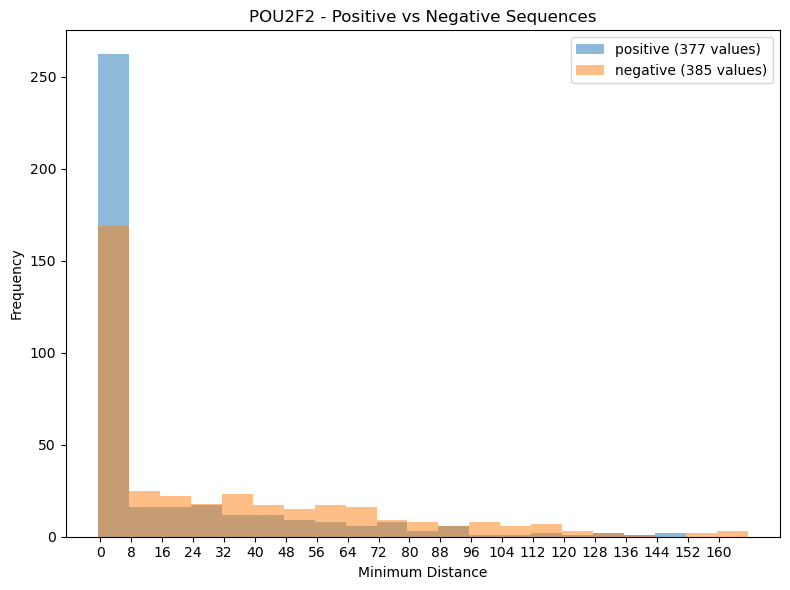

CTCF - Value Range: 151


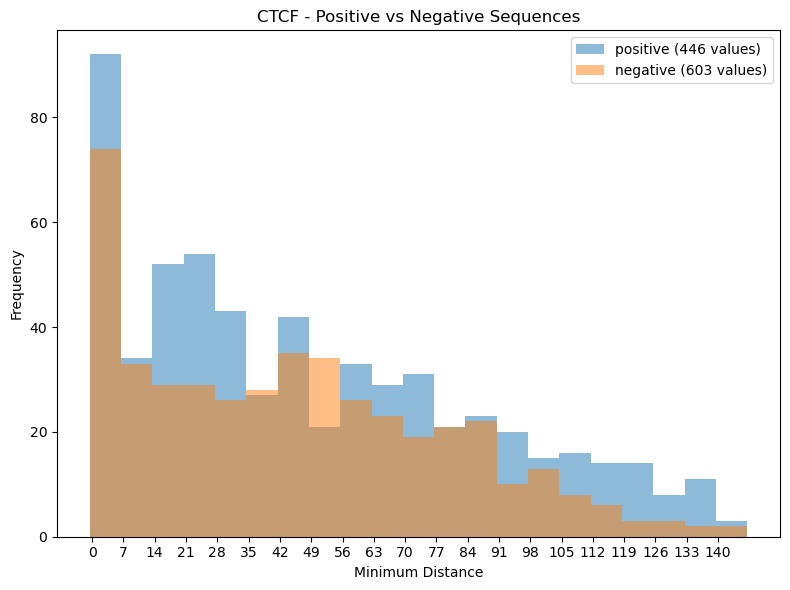

ETS1 - Value Range: 162


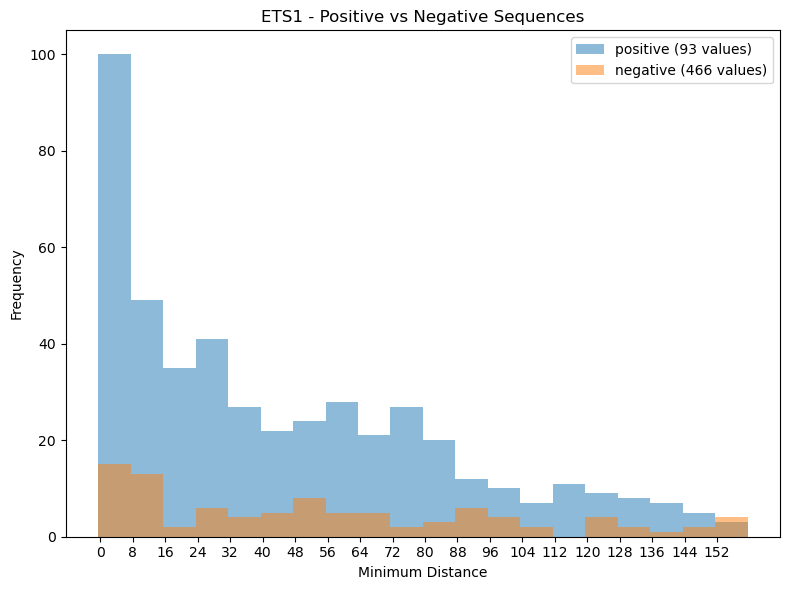

JUND - Value Range: 178


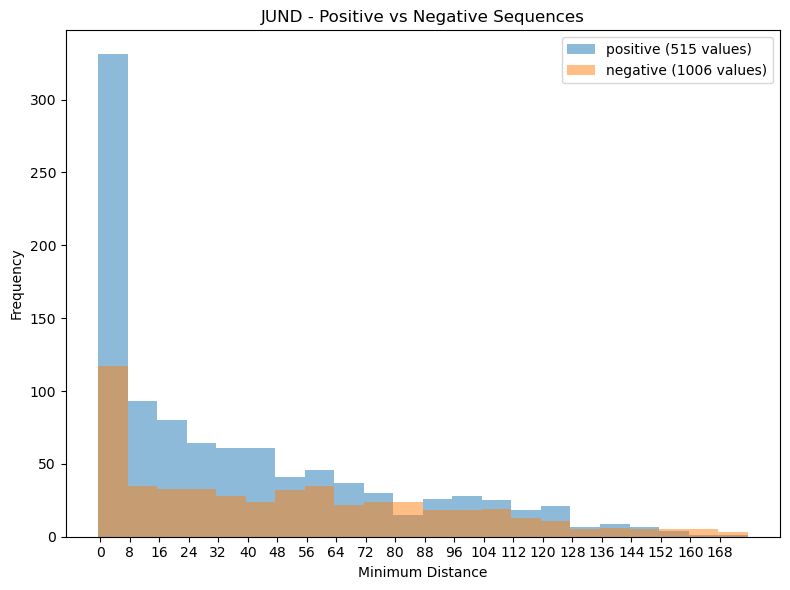

MAFK - Value Range: 175


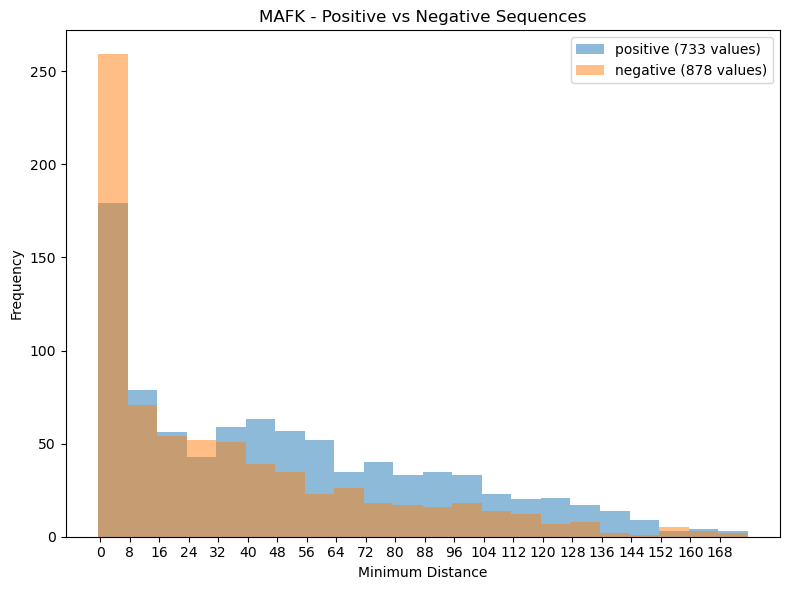

EBF1 - Value Range: 184


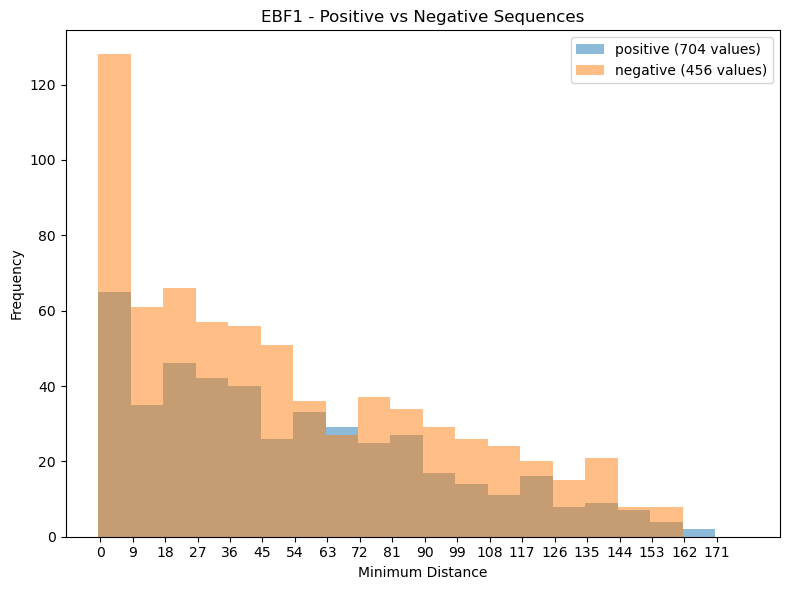

PAX5 - Value Range: 169


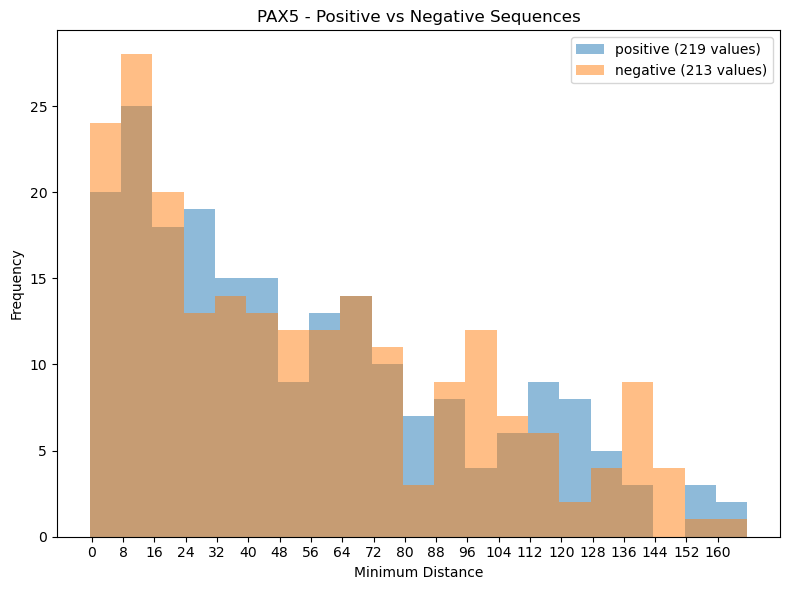

In [49]:
for tf in selected_tfs:
    positive_distances = []
    negative_distances = []
    for seq_id_p in positive_sequences[tf]:
        for seq_id in processed_features.keys():
            if seq_id == seq_id_p:
                positive_distances.append(processed_features[seq_id][tf]['min_distance'])
    for seq_id_p in negative_sequences[tf]:
        for seq_id in processed_features.keys():
            if seq_id == seq_id_p:
                negative_distances.append(processed_features[seq_id][tf]['min_distance'])

    # Calculate the range of values and determine bin edges
    if len(positive_distances) == 0 and len(negative_distances) == 0:
        value_range = 0
    else:
        value_range = max(max(positive_distances, default=0), max(negative_distances, default=0)) + 1

    print(f'{tf} - Value Range: {value_range}')

    # bin_edges = range(0, value_range + 2)  # +2 to include the last integer
    bin_edges = range(0, value_range + 2, value_range // 20)  # +2 to include the last integer


    # Create a subplot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create histograms for positive and negative distances on the same axes
    neg_hist, neg_edges, _ = ax.hist(negative_distances, bins=bin_edges, alpha=0.5, label='negative')
    pos_hist, pos_edges, _ = ax.hist(positive_distances, bins=bin_edges, alpha=0.5, label='positive')

    # Calculate total count of positive and negative data values
    total_pos = int(sum(pos_hist))
    total_neg = int(sum(neg_hist))

    # Add legend with total count annotations
    ax.legend([f'positive ({total_pos} values)', f'negative ({total_neg} values)'])

    ax.set_title(f'{tf} - Positive vs Negative Sequences')
    ax.set_xlabel('Minimum Distance')
    ax.set_ylabel('Frequency')

    # Center-align xticks
    ax.set_xticks([edge + 0.5 for edge in bin_edges[:-1]])
    ax.set_xticklabels([str(int(edge)) for edge in bin_edges[:-1]])

    plt.tight_layout()
    # save the plot
    plt.savefig(f'/project2/xinhe/waqaas/website/DNA-breathing/figs/phase4_new/binding_posvneg_distance/{tf}_positive_vs_negative_sequences.png')
    plt.show()


In [50]:
# run a wilcoxon rank sum test on the positive and negative distances
for tf in selected_tfs:
    positive_distances = []
    negative_distances = []
    for seq_id_p in positive_sequences[tf]:
        for seq_id in processed_features.keys():
            if seq_id == seq_id_p:
                positive_distances.append(processed_features[seq_id][tf]['min_distance'])
    for seq_id_p in negative_sequences[tf]:
        for seq_id in processed_features.keys():
            if seq_id == seq_id_p:
                negative_distances.append(processed_features[seq_id][tf]['min_distance'])
    # Perform Wilcoxon rank sum test
    stat, p_value = ranksums(positive_distances, negative_distances)
    
    # Print results
    print(f"TF: {tf}")
    print(f"Wilcoxon Rank Sum Test:")
    print(f"Statistic: {stat}")
    print(f"P-value: {p_value}\n")

TF: POU2F2
Wilcoxon Rank Sum Test:
Statistic: 6.174177568609378
P-value: 6.650875984727304e-10

TF: CTCF
Wilcoxon Rank Sum Test:
Statistic: -1.0749757040039771
P-value: 0.2823856060949631

TF: ETS1
Wilcoxon Rank Sum Test:
Statistic: 1.9622143384916308
P-value: 0.04973753527480944

TF: JUND
Wilcoxon Rank Sum Test:
Statistic: 5.835870085338569
P-value: 5.351057943278217e-09

TF: MAFK
Wilcoxon Rank Sum Test:
Statistic: -8.106068237798608
P-value: 5.228408871647506e-16

TF: EBF1
Wilcoxon Rank Sum Test:
Statistic: -1.1178571866547458
P-value: 0.2636279928242401

TF: PAX5
Wilcoxon Rank Sum Test:
Statistic: -0.13720022323997952
P-value: 0.8908725344595974



In [51]:
thresholds = [2, 3, 4, 5, 10, 20, 40, 80]  # List of 'close' thresholds to test

# Create a dictionary to store p-values for each threshold
p_value_dict = {}
odds_ratio_dict = {}

for threshold in thresholds:
    p_value_dict[threshold] = []
    odds_ratio_dict[threshold] = []

    for tf in selected_tfs:
        positive_distances = []
        negative_distances = []

        for seq_id_p in positive_sequences[tf]:
            for seq_id in processed_features.keys():
                if seq_id == seq_id_p:
                    close = 0
                    if processed_features[seq_id][tf]['min_distance'] < threshold:
                        close = 1
                    positive_distances.append(close)

        for seq_id_p in negative_sequences[tf]:
            for seq_id in processed_features.keys():
                if seq_id == seq_id_p:
                    close = 0
                    if processed_features[seq_id][tf]['min_distance'] < threshold:
                        close = 1
                    negative_distances.append(close)

        # Contingency table
        contingency_table = [[sum(positive_distances), len(positive_distances) - sum(positive_distances)],
                             [sum(negative_distances), len(negative_distances) - sum(negative_distances)]]

        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact(contingency_table)

        p_value_dict[threshold].append(p_value)
        odds_ratio_dict[threshold].append(odds_ratio)

# Create a DataFrame to store the p-values for different thresholds, and add thresholds as the header column's name
p_value_df = pd.DataFrame.from_dict(p_value_dict, orient='index', columns=selected_tfs)
odds_ratio_df = pd.DataFrame.from_dict(odds_ratio_dict, orient='index', columns=selected_tfs)

for tf in selected_tfs:
    for row in odds_ratio_df.index:
        # add in the p-value in brackets, and if p-value is less than 0.05, add an asterisk
        if p_value_df.at[row, tf] < 0.05:
            odds_ratio_df.at[row, tf] = f"{odds_ratio_df.at[row, tf]:.2f} ({p_value_df.at[row, tf]:.6f}*)"
        else:
            odds_ratio_df.at[row, tf] = f"{odds_ratio_df.at[row, tf]:.2f} ({p_value_df.at[row, tf]:.6f})"

In [52]:
print(odds_ratio_df.to_markdown())

|    | POU2F2           | CTCF            | ETS1             | JUND             | MAFK             | EBF1             | PAX5            |
|---:|:-----------------|:----------------|:-----------------|:-----------------|:-----------------|:-----------------|:----------------|
|  2 | 0.41 (0.000000*) | 1.04 (0.845010) | 0.77 (0.519669)  | 0.62 (0.000626*) | 1.96 (0.000000*) | 1.74 (0.012613*) | 0.97 (1.000000) |
|  3 | 0.40 (0.000000*) | 1.12 (0.568836) | 0.71 (0.428270)  | 0.62 (0.000361*) | 2.03 (0.000000*) | 1.90 (0.002689*) | 0.97 (1.000000) |
|  4 | 0.39 (0.000000*) | 1.05 (0.853470) | 0.72 (0.360480)  | 0.60 (0.000110*) | 2.10 (0.000000*) | 1.69 (0.010367*) | 0.90 (0.848836) |
|  5 | 0.39 (0.000000*) | 1.02 (0.928810) | 0.65 (0.233441)  | 0.60 (0.000092*) | 2.11 (0.000000*) | 1.59 (0.017313*) | 0.91 (0.853218) |
| 10 | 0.39 (0.000000*) | 1.25 (0.172221) | 0.63 (0.140613)  | 0.59 (0.000015*) | 1.97 (0.000000*) | 1.38 (0.056996)  | 1.19 (0.566375) |
| 20 | 0.43 (0.000000*) | 1.07 (0.

In [53]:
# # run a fisher exact test on the positive and negative distances
# threshold = [2, 3, 4, 5, 6]  # List of 'close' thresholds to test
# for limit in threshold:
#     for tf in panset.keys():
#         if tf == 'mad':
#             continue
#         positive_distances = []
#         negative_distances = []
#         for seq_id_p in positive_sequences[tf]:
#             for seq_id in panset[tf].keys():
#                 if seq_id == seq_id_p:
#                     close = 0
#                     if processed_features[seq_id][tf]['min_distance'] < limit:
#                         close = 1
#                     positive_distances.append(close)
#         for seq_id_p in negative_sequences[tf]:
#             for seq_id in panset[tf].keys():
#                 if seq_id == seq_id_p:
#                     close = 0
#                     if processed_features[seq_id][tf]['min_distance'] < limit:
#                         close = 1
#                     negative_distances.append(close)
#         # Contingency table
#         contingency_table = [[sum(positive_distances), len(positive_distances) - sum(positive_distances)], [sum(negative_distances), len(negative_distances) - sum(negative_distances)]]

#         # Perform Fisher's exact test
#         odds_ratio, p_value = fisher_exact(contingency_table)

#         # Print results
#         print(f"Threshold: {limit}")
#         print(f"TF: {tf}")
#         print(f"Contingency Table:")
#         print(f"         | Close | Far")
#         print(f"Positive |   {sum(positive_distances)}   |   {len(positive_distances) - sum(positive_distances)}")
#         print(f"Negative |   {sum(negative_distances)}   |   {len(negative_distances) - sum(negative_distances)}")
#         print(f"Odds Ratio: {odds_ratio}")
#         print(f"P-value: {p_value}\n")

In [54]:
# lets check overall number of strong motifs, weak motifs, and no motifs, and see how many sequences have both strong motifs and weak motifs
for tf in selected_tfs:
    strong_motifs = 0
    weak_motifs = 0
    no_motifs = 0
    both_motifs = 0
    for seq_id in processed_features.keys():
        if processed_features[seq_id][tf]['strong_motif_binary'] == 1 and processed_features[seq_id][tf]['weak_motif_binary'] == 1:
            both_motifs += 1
        elif processed_features[seq_id][tf]['strong_motif_binary'] == 1:
            strong_motifs += 1
        elif processed_features[seq_id][tf]['weak_motif_binary'] == 1:
            weak_motifs += 1
        elif processed_features[seq_id][tf]['strong_motif_binary'] == 0 and processed_features[seq_id][tf]['weak_motif_binary'] == 0:
            no_motifs += 1
    print(f'{tf} strong motifs: {strong_motifs}')
    print(f'{tf} weak motifs: {weak_motifs}')
    print(f'{tf} both motifs: {both_motifs}')
    print(f'{tf} no motifs: {no_motifs}')

POU2F2 strong motifs: 730
POU2F2 weak motifs: 4012
POU2F2 both motifs: 385
POU2F2 no motifs: 21264
CTCF strong motifs: 4727
CTCF weak motifs: 1674
CTCF both motifs: 1227
CTCF no motifs: 18763
ETS1 strong motifs: 1302
ETS1 weak motifs: 9171
ETS1 both motifs: 1088
ETS1 no motifs: 14830
JUND strong motifs: 1472
JUND weak motifs: 1847
JUND both motifs: 1475
JUND no motifs: 21597
MAFK strong motifs: 2026
MAFK weak motifs: 4214
MAFK both motifs: 1419
MAFK no motifs: 18732
EBF1 strong motifs: 2714
EBF1 weak motifs: 1566
EBF1 both motifs: 1487
EBF1 no motifs: 20624
PAX5 strong motifs: 814
PAX5 weak motifs: 10133
PAX5 both motifs: 1138
PAX5 no motifs: 14306


In [55]:
# create strong_motif_seq and weak_motif_seq for each sequence
for tf in selected_tfs:
    for seq_id in processed_features.keys():
        processed_features[seq_id][tf]['strong_motif_seq'] = np.zeros(200)
        processed_features[seq_id][tf]['weak_motif_seq'] = np.zeros(200)
        for i in range(200):
            if 0 < processed_features[seq_id][tf]['p-value_positive'][i] <= 0.0001 or 0 < processed_features[seq_id][tf]['p-value_negative'][i] <= 0.0001:
                processed_features[seq_id][tf]['strong_motif_seq'][i] = 1
            elif processed_features[seq_id][tf]['p-value_positive'][i] > 0.0001 or processed_features[seq_id][tf]['p-value_negative'][i] > 0.0001:
                processed_features[seq_id][tf]['weak_motif_seq'][i] = 1

In [56]:
models_no_strong = {}

for n, tf in enumerate(selected_tfs):
    data[tf] = []
    for seq_id in affinity[tf].keys():
        if seq_id in processed_features.keys() and processed_features[seq_id][tf]['strong_motif_binary'] == 0:
            data_point = {
                'bubble_binary': processed_features[seq_id]['bubble_binary'],
                'binding_affinity': processed_features[seq_id]['tf_label'][n]
            }

            # Append the data point to the appropriate list based on the presence of motif and bubble
            data[tf].append(data_point)

    # Create pandas DataFrame for each TF
    df = pd.DataFrame(data[tf])

    # Perform logistic regression for each case
    model_bubble = perform_logistic_regression(df, ['bubble_binary'], 'binding_affinity')

    # Store the models for each TF
    models_no_strong[tf] = {'bubble_only': model_bubble}

Optimization terminated successfully.
         Current function value: 87.832356
         Iterations 5
Optimization terminated successfully.
         Current function value: 106.812965
         Iterations 5
Optimization terminated successfully.
         Current function value: 253.820632
         Iterations 7
Optimization terminated successfully.
         Current function value: 178.781461
         Iterations 6
Optimization terminated successfully.
         Current function value: 116.165153
         Iterations 5
Optimization terminated successfully.
         Current function value: 76.677326
         Iterations 5
Optimization terminated successfully.
         Current function value: 84.878188
         Iterations 5


In [57]:
# Access the models for each TF as needed
for tf in selected_tfs:
    print(f"\nTF = {tf}")
    print("\nLogistic Regression with Bubble Feature Only:")
    print(models_no_strong[tf]['bubble_only'].summary())


TF = POU2F2

Logistic Regression with Bubble Feature Only:
                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                25276
Model:                          Logit   Df Residuals:                    25275
Method:                           MLE   Df Model:                            0
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:04:40   Log-Likelihood:            -2.2201e+06
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
bubble_binary    -1.1787      0.024    -48.981      0.000      -1.226      -1.132

TF = CTCF

Logistic Regression with Bubble Feature Only:


/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverti

                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                20437
Model:                          Logit   Df Residuals:                    20436
Method:                           MLE   Df Model:                            0
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:04:40   Log-Likelihood:            -2.1829e+06
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
bubble_binary    -1.1926      0.025    -48.630      0.000      -1.241      -1.145

TF = ETS1

Logistic Regression with Bubble Feature Only:
                           Logit Regression Results             

/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverti

                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                23444
Model:                          Logit   Df Residuals:                    23443
Method:                           MLE   Df Model:                            0
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:04:40   Log-Likelihood:            -4.1914e+06
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
bubble_binary    -2.0851      0.034    -61.464      0.000      -2.152      -2.019

TF = MAFK

Logistic Regression with Bubble Feature Only:
                           Logit Regression Results             

/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                22190
Model:                          Logit   Df Residuals:                    22189
Method:                           MLE   Df Model:                            0
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:04:41   Log-Likelihood:            -1.7015e+06
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
bubble_binary    -0.9883      0.023    -42.140      0.000      -1.034      -0.942

TF = PAX5

Logistic Regression with Bubble Feature Only:
                           Logit Regression Results             

/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: di

In [58]:
for tf in selected_tfs:
    for seq_id in processed_features.keys():
        flip = []
        coord = []
        coordsq = []
        for i in range(200):
            if processed_features[seq_id][tf]['motif_seq'][i] == 1:
                flip.append(processed_features[seq_id]['flipping'][i])
                coord.append(processed_features[seq_id]['coords'][i])
                coordsq.append(processed_features[seq_id]['coordssquared'][i])
        # append the average feature value to the dictionary
        if len(flip) == 0:
            processed_features[seq_id][tf]['motif_flip'] = 0
            processed_features[seq_id][tf]['motif_coord'] = 0
            processed_features[seq_id][tf]['motif_coordsq'] = 0
        else:
            processed_features[seq_id][tf]['motif_flip'] = mean(flip)
            processed_features[seq_id][tf]['motif_coord'] = mean(coord)
            processed_features[seq_id][tf]['motif_coordsq'] = mean(coordsq)

In [59]:
correlation_results = {}

for n, tf in enumerate(selected_tfs):
    motif_flip = []
    motif_coord = []
    motif_coordsq = []
    binding_affinity = []  # Labels

    for seq_id in processed_features.keys():
        if processed_features[seq_id][tf]['strong_motif_binary'] == 1:
            motif_flip.append(processed_features[seq_id][tf]['motif_flip'])
            motif_coord.append(processed_features[seq_id][tf]['motif_coord'])
            motif_coordsq.append(processed_features[seq_id][tf]['motif_coordsq'])
            binding_affinity.append(processed_features[seq_id]['tf_label'][n])

    # Calculate point biserial correlation coefficient and p-value for each feature
    corr_flip, p_value_flip = pointbiserialr(motif_flip, binding_affinity)
    corr_coord, p_value_coord = pointbiserialr(motif_coord, binding_affinity)
    corr_coordsq, p_value_coordsq = pointbiserialr(motif_coordsq, binding_affinity)

    # round the correlation coefficients to 2 decimal places and the p-values to 6 decimal places
    corr_flip = round(corr_flip, 4)
    p_value_flip = round(p_value_flip, 6)
    corr_coord = round(corr_coord, 4)
    p_value_coord = round(p_value_coord, 6)
    corr_coordsq = round(corr_coordsq, 4)
    p_value_coordsq = round(p_value_coordsq, 6)

    correlation_results[tf] = {
        'motif_flip': (corr_flip, p_value_flip),
        'motif_coord': (corr_coord, p_value_coord),
        'motif_coordsq': (corr_coordsq, p_value_coordsq),
    }

    # display the correlation results in a df
    correlation_df = pd.DataFrame(correlation_results)

    # # Create scatterplots with lines of best fit
    # plt.figure(figsize=(18, 6))
    # # add a title
    # plt.suptitle(f'{tf} - Motif Feature vs Binding Affinity')

    # plt.subplot(131)
    # plt.scatter(motif_flip, binding_affinity, label=f'Correlation = {corr_flip:.2f}', color="blue")
    # m, b = np.polyfit(motif_flip, binding_affinity, 1)
    # plt.plot(motif_flip, m * np.array(motif_flip) + b, color='red', linestyle='--', label='Line of Best Fit')
    # plt.xlabel(f'Motif Flip Feature (p-value = {p_value_flip})')
    # plt.ylabel('Binding Affinity')
    # plt.legend()

    # plt.subplot(132)
    # plt.scatter(motif_coord, binding_affinity, label=f'Correlation = {corr_coord:.2f}', color='green')
    # m, b = np.polyfit(motif_coord, binding_affinity, 1)
    # plt.plot(motif_coord, m * np.array(motif_coord) + b, color='red', linestyle='--', label='Line of Best Fit')
    # plt.xlabel(f'Motif Coord Feature (p-value = {p_value_coord})')
    # plt.ylabel('Binding Affinity')
    # plt.legend()

    # plt.subplot(133)
    # plt.scatter(motif_coordsq, binding_affinity, label=f'Correlation = {corr_coordsq:.2f}', color='purple')
    # m, b = np.polyfit(motif_coordsq, binding_affinity, 1)
    # plt.plot(motif_coordsq, m * np.array(motif_coordsq) + b, color='red', linestyle='--', label='Line of Best Fit')
    # plt.xlabel(f'Motif Coord^2 Feature (p-value = {p_value_coordsq})')
    # plt.ylabel('Binding Affinity')
    # plt.legend()

    # plt.tight_layout()
    # plt.show()

    # # Clear the figure to create a new one for the next TF
    # plt.clf()


In [60]:
correlation_df = correlation_df.T
# rename the columns
correlation_df.columns = ['Motif Flip', 'Motif Coord', 'Motif Coord^2']
correlation_df

,Motif Flip,Motif Coord,Motif Coord^2
POU2F2,"(-0.3305, 0.0)","(-0.3226, 0.0)","(-0.3396, 0.0)"
CTCF,"(-0.0372, 0.004075)","(-0.0363, 0.005045)","(-0.0372, 0.004115)"
ETS1,"(-0.3105, 0.0)","(-0.3118, 0.0)","(-0.3176, 0.0)"
JUND,"(-0.1678, 0.0)","(-0.1699, 0.0)","(-0.1761, 0.0)"
MAFK,"(0.2061, 0.0)","(0.2228, 0.0)","(0.2124, 0.0)"
EBF1,"(0.2046, 0.0)","(0.1926, 0.0)","(0.2051, 0.0)"
PAX5,"(0.0082, 0.718219)","(0.0197, 0.384439)","(0.0065, 0.773541)"


In [61]:
# if the p-value is less than 0.05, then add an asterisk in the df
for tf in selected_tfs:
    for feature in correlation_df.columns:
        if correlation_df.at[tf, feature][1] < 0.05:
            correlation_df.at[tf, feature] = f"{correlation_df.at[tf, feature][0]:.2f} ({correlation_df.at[tf, feature][1]:.6f}*)"
        else:
            correlation_df.at[tf, feature] = f"{correlation_df.at[tf, feature][0]:.2f} ({correlation_df.at[tf, feature][1]:.6f})"

In [62]:
print(correlation_df.to_markdown())

|        | Motif Flip        | Motif Coord       | Motif Coord^2     |
|:-------|:------------------|:------------------|:------------------|
| POU2F2 | -0.33 (0.000000*) | -0.32 (0.000000*) | -0.34 (0.000000*) |
| CTCF   | -0.04 (0.004075*) | -0.04 (0.005045*) | -0.04 (0.004115*) |
| ETS1   | -0.31 (0.000000*) | -0.31 (0.000000*) | -0.32 (0.000000*) |
| JUND   | -0.17 (0.000000*) | -0.17 (0.000000*) | -0.18 (0.000000*) |
| MAFK   | 0.21 (0.000000*)  | 0.22 (0.000000*)  | 0.21 (0.000000*)  |
| EBF1   | 0.20 (0.000000*)  | 0.19 (0.000000*)  | 0.21 (0.000000*)  |
| PAX5   | 0.01 (0.718219)   | 0.02 (0.384439)   | 0.01 (0.773541)   |


In [63]:
for tf in selected_tfs:
    count = []
    for seq_id in processed_features.keys():
        count.append(sum(processed_features[seq_id][tf]['motif_seq']))
    # display unique counts and their frequencies
    unique, counts = np.unique(count, return_counts=True)
    print(tf)
    print(dict(zip(unique, counts)))

POU2F2
{0.0: 21264, 13.0: 3972, 14.0: 7, 15.0: 30, 17.0: 6, 18.0: 7, 19.0: 65, 20.0: 4, 21.0: 42, 22.0: 13, 23.0: 12, 24.0: 9, 25.0: 10, 26.0: 705, 27.0: 4, 28.0: 19, 29.0: 2, 30.0: 1, 31.0: 3, 32.0: 23, 33.0: 1, 34.0: 16, 35.0: 6, 36.0: 10, 37.0: 3, 38.0: 1, 39.0: 106, 40.0: 1, 41.0: 4, 42.0: 2, 43.0: 1, 44.0: 3, 45.0: 5, 47.0: 5, 48.0: 3, 49.0: 2, 51.0: 2, 52.0: 13, 53.0: 2, 54.0: 1, 56.0: 1, 59.0: 1, 60.0: 1, 71.0: 1, 72.0: 1, 73.0: 1}
CTCF
{0.0: 18763, 33.0: 5244, 34.0: 14, 35.0: 17, 36.0: 180, 37.0: 1, 38.0: 6, 39.0: 20, 40.0: 7, 42.0: 61, 43.0: 98, 44.0: 9, 45.0: 69, 46.0: 128, 47.0: 13, 48.0: 8, 49.0: 22, 50.0: 5, 51.0: 2, 52.0: 23, 53.0: 9, 54.0: 7, 55.0: 21, 56.0: 27, 57.0: 8, 58.0: 23, 59.0: 35, 60.0: 3, 61.0: 38, 62.0: 12, 63.0: 13, 64.0: 20, 65.0: 23, 66.0: 866, 67.0: 5, 68.0: 16, 69.0: 76, 70.0: 6, 71.0: 3, 72.0: 19, 73.0: 6, 74.0: 7, 75.0: 31, 76.0: 39, 77.0: 5, 78.0: 18, 79.0: 41, 80.0: 5, 81.0: 6, 82.0: 21, 83.0: 5, 84.0: 3, 85.0: 12, 86.0: 2, 87.0: 5, 88.0: 15, 89.0: 1

In [64]:
# for tf in selected_tfs:
#     count = 0
#     for seq_id in processed_features.keys():
#         if processed_features[seq_id][tf]['strong_motif_binary'] == 1:
#             # count the number of ones in 'motif_seq'
#             count = sum(processed_features[seq_id][tf]['motif_seq'])
#     for i in range(int(count)):
#         for seq_id in processed_features.keys():
#             if processed_features[seq_id][tf]['strong_motif_binary'] == 1:
#                 temp = {}
#                 temp[f'motif_flip_{i}'] = []
#                 temp[f'motif_coord_{i}'] = []
#                 temp[f'motif_coordsq_{i}'] = []
#                 if sum(processed_features[seq_id][tf]['motif_seq_positive']) != 0:
#                     for j in range(200):
#                         if processed_features[seq_id][tf]['motif_seq_positive'][j] == 1:
#                             k = j + i
#                             temp[f'motif_flip_{i}'].append(processed_features[seq_id][tf]['flipping'][k])
#                             temp[f'motif_coord_{i}'].append(processed_features[seq_id][tf]['coords'][k])
#                             temp[f'motif_coordsq_{i}'].append(processed_features[seq_id][tf]['coordssquared'][k])
#                             break
#                 if sum(processed_features[seq_id][tf]['motif_seq_negative']) != 0:
#                     # reverse countdown from 35 to 0
#                     for j in range(35, -1, -1):
#                         if processed_features[seq_id][tf]['motif_seq_negative'][j] == 1:
#                             k = j - i
#                             temp[f'motif_flip_{i}'].append(processed_features[seq_id][tf]['flipping'][k])
#                             temp[f'motif_coord_{i}'].append(processed_features[seq_id][tf]['coords'][k])
#                             temp[f'motif_coordsq_{i}'].append(processed_features[seq_id][tf]['coordssquared'][k])
#                             break
#                 processed_features[seq_id][tf][f'motif_flip_{i}'] = sum(temp[f'motif_flip_{i}']) / len(temp[f'motif_flip_{i}'])
#                 processed_features[seq_id][tf][f'motif_coord_{i}'] = sum(temp[f'motif_coord_{i}']) / len(temp[f'motif_coord_{i}'])
#                 processed_features[seq_id][tf][f'motif_coordsq_{i}'] = sum(temp[f'motif_coordsq_{i}']) / len(temp[f'motif_coordsq_{i}'])

In [65]:
# correlation_data = {}

# for tf in panset.keys():
#     if tf == 'mad':
#         continue
#     correlation_data[tf] = {}
#     count = 0
#     for seq_id in panset[tf].keys():
#         if processed_features[seq_id][tf]['strong_motif_binary'] == 1:
#             # Count the number of ones in 'motif_seq'
#             count = sum(processed_features[seq_id][tf]['motif_seq'])
#     bar_graph = {}
#     for i in range(int(count)):
#         bar_graph[i] = {}
#         for feature in ['flip', 'coord', 'coordsq']:
#             correlation_data[tf][feature] = []
#         correlation_data[tf]['label_values'] = []
#         for seq_id in panset[tf].keys():
#             if processed_features[seq_id][tf]['strong_motif_binary'] == 1:
#                 for feature in ['flip', 'coord', 'coordsq']:
#                     correlation_data[tf][feature].append(processed_features[seq_id][tf][f'motif_{feature}_{i}'])
#                 correlation_data[tf]['label_values'].append(processed_features[seq_id][tf]['label'])

#         # Use correlation_data to calculate pearson correlation coefficients and p-values for each feature
#         for feature in ['flip', 'coord', 'coordsq']:
#             corr, p_value = pearsonr(correlation_data[tf][feature], correlation_data[tf]['label_values'])
#             bar_graph[i][feature] = {'p_value': p_value, 'correlation': corr}
#             print(f"\nTF = {tf}")
#             print(f"Pearson Correlation with Motif {feature} Feature: Correlation = {corr:.2f}, p-value = {p_value:.2e}")

#     # Create a bar graph for each feature: correlation vs. position (i) and -log10(p-value) vs. position (i)
#     for feature in ['flip', 'coord', 'coordsq']:
#         positions = list(bar_graph.keys())
#         correlations = [entry[feature]['correlation'] for entry in bar_graph.values()]
#         p_values = [-np.log10(entry[feature]['p_value']) for entry in bar_graph.values()]  # Take the negative log10 of p-values

#         plt.figure(figsize=(6, 6))
#         # add title
#         plt.suptitle(f'{tf} - Motif {feature} Feature vs Binding Affinity')

#         plt.subplot(121)
#         plt.bar(positions, correlations)
#         plt.xlabel('Position (i)')
#         plt.ylabel('Correlation')
#         plt.title(f'{feature}')
#         plt.xticks(positions, positions)  # Add numerical x-ticks

#         plt.subplot(122)
#         plt.bar(positions, p_values)
#         plt.xlabel('Position (i)')
#         plt.ylabel('-log10(p-value)')  # Change the y-axis label
#         plt.title(f'-log10(p-value)')
#         plt.grid(axis='y')
#         plt.xticks(positions, positions)  # Add numerical x-ticks

#         plt.tight_layout()
#         plt.show()


In [66]:
# for each tf, using only the sequences where weak_motif_binary = 1, do a logistic regression with the bubble feature against the label
models_only_weak = {}

for n, tf in enumerate(selected_tfs):
    data[tf] = []
    for seq_id in affinity[tf].keys():
        if seq_id in processed_features.keys() and processed_features[seq_id][tf]['weak_motif_binary'] == 1:
            data_point = {
                'bubble_binary': processed_features[seq_id]['bubble_binary'],
                'binding_affinity': processed_features[seq_id]['tf_label'][n]
            }

        # Append the data point to the appropriate list based on the presence of motif and bubble
            data[tf].append(data_point)

    # Create pandas DataFrame for each TF
    df = pd.DataFrame(data[tf])

    # Perform linear regression for each case
    model_bubble = perform_logistic_regression(df, ['bubble_binary'], 'binding_affinity')

    # Store the models for each TF
    models_only_weak[tf] = {'bubble_only': model_bubble}

Optimization terminated successfully.
         Current function value: 147.095699
         Iterations 5
Optimization terminated successfully.
         Current function value: 10.742108
         Iterations 4
Optimization terminated successfully.
         Current function value: 175.597368
         Iterations 6
Optimization terminated successfully.
         Current function value: 156.876356
         Iterations 5
Optimization terminated successfully.
         Current function value: 55.572167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603098
         Iterations 3
Optimization terminated successfully.
         Current function value: 22.395543
         Iterations 4


In [67]:
# Access the models for each TF as needed
for tf in selected_tfs:
    print(f"\nTF = {tf}")
    print("\nLinear Regression with Bubble Feature Only:")
    print(models_only_weak[tf]['bubble_only'].summary())


TF = POU2F2

Linear Regression with Bubble Feature Only:
                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                 4397
Model:                          Logit   Df Residuals:                     4396
Method:                           MLE   Df Model:                            0
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:05:00   Log-Likelihood:            -6.4678e+05
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
bubble_binary    -1.1056      0.042    -26.368      0.000      -1.188      -1.023

TF = CTCF

Linear Regression with Bubble Feature Only:
        

/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverti

                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                10259
Model:                          Logit   Df Residuals:                    10258
Method:                           MLE   Df Model:                            0
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:05:00   Log-Likelihood:            -1.8015e+06
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
bubble_binary    -2.3398      0.061    -38.055      0.000      -2.460      -2.219

TF = JUND

Linear Regression with Bubble Feature Only:
                           Logit Regression Results               

/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverti

                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                 3053
Model:                          Logit   Df Residuals:                     3052
Method:                           MLE   Df Model:                            0
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:05:00   Log-Likelihood:                -1841.3
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
bubble_binary     0.1141      0.072      1.583      0.113      -0.027       0.255

TF = PAX5

Linear Regression with Bubble Feature Only:
                           Logit Regression Results               

/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


In [68]:
# display all regressions per tf that have only bubbles
for tf in selected_tfs:
    print(f"\nTF = {tf}")
    print(models[tf]['bubble_only'].summary())
    print(models_no_strong[tf]['bubble_only'].summary())
    print(models_only_weak[tf]['bubble_only'].summary())


TF = POU2F2


/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                26391
Model:                          Logit   Df Residuals:                    26390
Method:                           MLE   Df Model:                            0
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:05:01   Log-Likelihood:            -2.1329e+06
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
bubble_binary    -1.0754      0.023    -47.670      0.000      -1.120      -1.031
                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No.

/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: di

                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                26391
Model:                          Logit   Df Residuals:                    26390
Method:                           MLE   Df Model:                            0
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:05:01   Log-Likelihood:            -2.1611e+06
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
bubble_binary    -1.0867      0.023    -48.034      0.000      -1.131      -1.042
                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No.

/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                26391
Model:                          Logit   Df Residuals:                    26390
Method:                           MLE   Df Model:                            0
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:05:01   Log-Likelihood:            -6.2085e+06
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
bubble_binary    -2.5318      0.038    -67.311      0.000      -2.606      -2.458
                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No.

/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                26391
Model:                          Logit   Df Residuals:                    26390
Method:                           MLE   Df Model:                            0
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:05:01   Log-Likelihood:            -4.0438e+06
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
bubble_binary    -1.7822      0.028    -63.691      0.000      -1.837      -1.727
                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No.

/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: di

                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                26391
Model:                          Logit   Df Residuals:                    26390
Method:                           MLE   Df Model:                            0
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:05:01   Log-Likelihood:            -2.4816e+06
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
bubble_binary    -1.2119      0.023    -51.858      0.000      -1.258      -1.166
                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No.

/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                26391
Model:                          Logit   Df Residuals:                    26390
Method:                           MLE   Df Model:                            0
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:05:02   Log-Likelihood:            -1.4848e+06
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
bubble_binary    -0.8052      0.021    -37.867      0.000      -0.847      -0.764
                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No.

/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                26391
Model:                          Logit   Df Residuals:                    26390
Method:                           MLE   Df Model:                            0
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:05:02   Log-Likelihood:            -2.0263e+06
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
bubble_binary    -1.0326      0.022    -46.248      0.000      -1.076      -0.989
                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No.

/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


# Count regressions and distance analyses

In [69]:
# a logistic regression to see if the number of bubbles in a sequence correlates with the binding affinity
models_bubble_count = {}

for n, tf in enumerate(selected_tfs):
    data[tf] = []
    for seq_id in processed_features.keys():
        if processed_features[seq_id][tf]['weak_motif_binary'] == 1 and processed_features[seq_id][tf]['strong_motif_binary'] == 0:
            data_point = {
                'bubble_count': processed_features[seq_id]['bubble_count'],
                'binding_affinity': processed_features[seq_id]['tf_label'][n]
            }

            # Append the data point to the appropriate list based on the presence of motif and bubble
            data[tf].append(data_point)

    # Create pandas DataFrame for each TF
    df = pd.DataFrame(data[tf])

    # Perform logistic regression for each case
    model_bubble = perform_logistic_regression(df, ['bubble_count'], 'binding_affinity')

    # Store the models for each TF
    models_bubble_count[tf] = {'bubble_count': model_bubble}

/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: 18.944160
         Iterations 5


/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Optimization terminated successfully.
         Current function value: 39.638844
         Iterations 5
Optimization terminated successfully.
         Current function value: 9.062446
         Iterations 4
Optimization terminated successfully.
         Current function value: 25.647457
         Iterations 5


In [70]:
# Access the models for each TF as needed
for tf in selected_tfs:
    print(f"\nTF = {tf}")
    print("\nLogistic Regression with Bubble Count Feature:")
    print(models_bubble_count[tf]['bubble_count'].summary())


TF = POU2F2

Logistic Regression with Bubble Count Feature:
                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                 4012
Model:                          Logit   Df Residuals:                     4011
Method:                           MLE   Df Model:                            0
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:05:03   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                       nan
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
bubble_count    -0.5462      0.022    -24.425      0.000      -0.590      -0.502

TF = CTCF

Logistic Regression with Bubble Count Feature:
     

/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  war

                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                 9171
Model:                          Logit   Df Residuals:                     9170
Method:                           MLE   Df Model:                            0
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:05:03   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                       nan
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
bubble_count    -1.7547      0.055    -31.622      0.000      -1.863      -1.646

TF = JUND

Logistic Regression with Bubble Count Feature:
                           Logit Regression Results               

/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverti

In [71]:
# a logistic regression to see if the number of bubbles in a sequence correlates with the binding affinity
models_bubble_count_no_motif = {}

for n, tf in enumerate(selected_tfs):
    data[tf] = []
    for seq_id in processed_features.keys():
        if processed_features[seq_id][tf]['weak_motif_binary'] == 0 and processed_features[seq_id][tf]['strong_motif_binary'] == 0:
            data_point = {
                'bubble_count': processed_features[seq_id]['bubble_count'],
                'binding_affinity': processed_features[seq_id]['tf_label'][n]
            }

            # Append the data point to the appropriate list based on the presence of motif and bubble
            data[tf].append(data_point)

    # Create pandas DataFrame for each TF
    df = pd.DataFrame(data[tf])

    # Perform logistic regression for each case
    model_bubble = perform_logistic_regression(df, ['bubble_count'], 'binding_affinity')

    # Store the models for each TF
    models_bubble_count_no_motif[tf] = {'bubble_count': model_bubble}

/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 6


/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 8


/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 7


/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 5
Optimization terminated successfully.
         Current function value: inf
         Iterations 5
Optimization terminated successfully.
         Current function value: inf
         Iterations 6


/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


In [72]:
# Access the models for each TF as needed
for tf in selected_tfs:
    print(f"\nTF = {tf}")
    print("\nLogistic Regression with Bubble Count Feature:")
    print(models_bubble_count_no_motif[tf]['bubble_count'].summary())


TF = POU2F2

Logistic Regression with Bubble Count Feature:
                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                21264
Model:                          Logit   Df Residuals:                    21263
Method:                           MLE   Df Model:                            0
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:05:05   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                       nan
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
bubble_count    -0.6125      0.017    -35.861      0.000      -0.646      -0.579

TF = CTCF

Logistic Regression with Bubble Count Feature:


/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  war

                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                18763
Model:                          Logit   Df Residuals:                    18762
Method:                           MLE   Df Model:                            0
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:05:05   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                       nan
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
bubble_count    -0.6253      0.014    -43.938      0.000      -0.653      -0.597

TF = ETS1

Logistic Regression with Bubble Count Feature:
                           Logit Regression Results               

/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  war

                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                21597
Model:                          Logit   Df Residuals:                    21596
Method:                           MLE   Df Model:                            0
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:05:06   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                       nan
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
bubble_count    -1.1588      0.024    -48.290      0.000      -1.206      -1.112

TF = MAFK

Logistic Regression with Bubble Count Feature:
                           Logit Regression Results               

/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  war

                           Logit Regression Results                           
Dep. Variable:       binding_affinity   No. Observations:                20624
Model:                          Logit   Df Residuals:                    20623
Method:                           MLE   Df Model:                            0
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     inf
Time:                        19:05:06   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                       nan
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
bubble_count    -0.4619      0.012    -37.162      0.000      -0.486      -0.438

TF = PAX5

Logistic Regression with Bubble Count Feature:
                           Logit Regression Results               

/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/waqaas/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


In [73]:
# p-value sorter and distance calculator
pvalue_dict = {}
for tf in selected_tfs:
    pvalue_dict[tf] = {}
    for seq_id in processed_features.keys():
        pvalue_dict[tf][seq_id] = set(processed_features[seq_id][tf]['p-value_positive']).union(set(processed_features[seq_id][tf]['p-value_negative']))
        # sort in ascending order
        pvalue_dict[tf][seq_id] = sorted(pvalue_dict[tf][seq_id])

pvalue_df_dict = {}
for tf in selected_tfs:
    n = 0
    pvalue_df_dict[tf] = {}
    for seq_id in processed_features.keys():
        for pvalue in pvalue_dict[tf][seq_id]:
            if pvalue == 0:
                continue
            pvalue_df_dict[tf][n] = {'seq_id': seq_id, 'pvalue': pvalue}
            n += 1

In [74]:
pvalue_df = {}
for tf in selected_tfs:
    pvalue_df[tf] = pd.DataFrame(pvalue_df_dict[tf])
    pvalue_df[tf] = pvalue_df[tf].T
    pvalue_df[tf] = pvalue_df[tf].sort_values(by=['pvalue'])

In [75]:
pvalue_df['POU2F2'].head()

,seq_id,pvalue
2752,259889,0.0
1965,337892,0.0
6495,6690345,0.0
1199,183127,0.0
5774,5437354,0.0


In [76]:
# distance calculator
distance_dict = {}
for tf in selected_tfs:
    distance_dict[tf] = []
    pos_count = 0
    neg_count = 0
    for index in pvalue_df[tf].index:
        if min(pos_count, neg_count) == 300:
            break
        seq_id = pvalue_df[tf].at[index, 'seq_id']
        pvalue = pvalue_df[tf].at[index, 'pvalue']
        motif = np.zeros(200)
        # turn indices where p-value_positive or p-value_negative is equal to pvalue to 1
        for i in range(200):
            if processed_features[seq_id][tf]['p-value_positive'][i] == pvalue or processed_features[seq_id][tf]['p-value_negative'][i] == pvalue:
                motif[i] = 1
        bubble_seq = processed_features[seq_id]['bubble_seq']
        label = processed_features[seq_id]['tf_label'][selected_tfs.index(tf)]

        # calculate starts and ends
        starts = []
        ends = []
        flip = 0
        for i in range(200):
            if flip == 0:
                if motif[i] == 1:
                    starts.append(i)
                    flip = 1
            elif flip == 1:
                if motif[i] == 0:
                    ends.append(i)
                    flip = 0
                elif i == 199:
                    ends.append(i)

        for start, end in zip(starts, ends):
            distances = [200]
            # if there is a 0 between start and stop, raise an error
            if 0 in motif[start:end]:
                print(f'Error: {seq_id} {tf}')
                print(motif)
            # first check if the motif is in the bubble
            if sum(bubble_seq[start:end]) != 0:
                distance = 0
                distances.append(distance)
            elif sum(bubble_seq[start:end]) == 0:
                # if not, calculate the distance
                # check backwards from the start of the motif
                for i in range(start-1, -1, -1):
                    distance += 1
                    if bubble_seq[i] == 1:
                        distances.append(distance)
                        break
                # check forwards from the end of the motif
                for i in range(end+1, 200):
                    distance += 1
                    if bubble_seq[i] == 1:
                        distances.append(distance)
                        break
            min_distance = min(distances)
            distance_dict[tf].append((min_distance, label))
            if label == 1:
                pos_count += 1
            elif label == 0:
                neg_count += 1

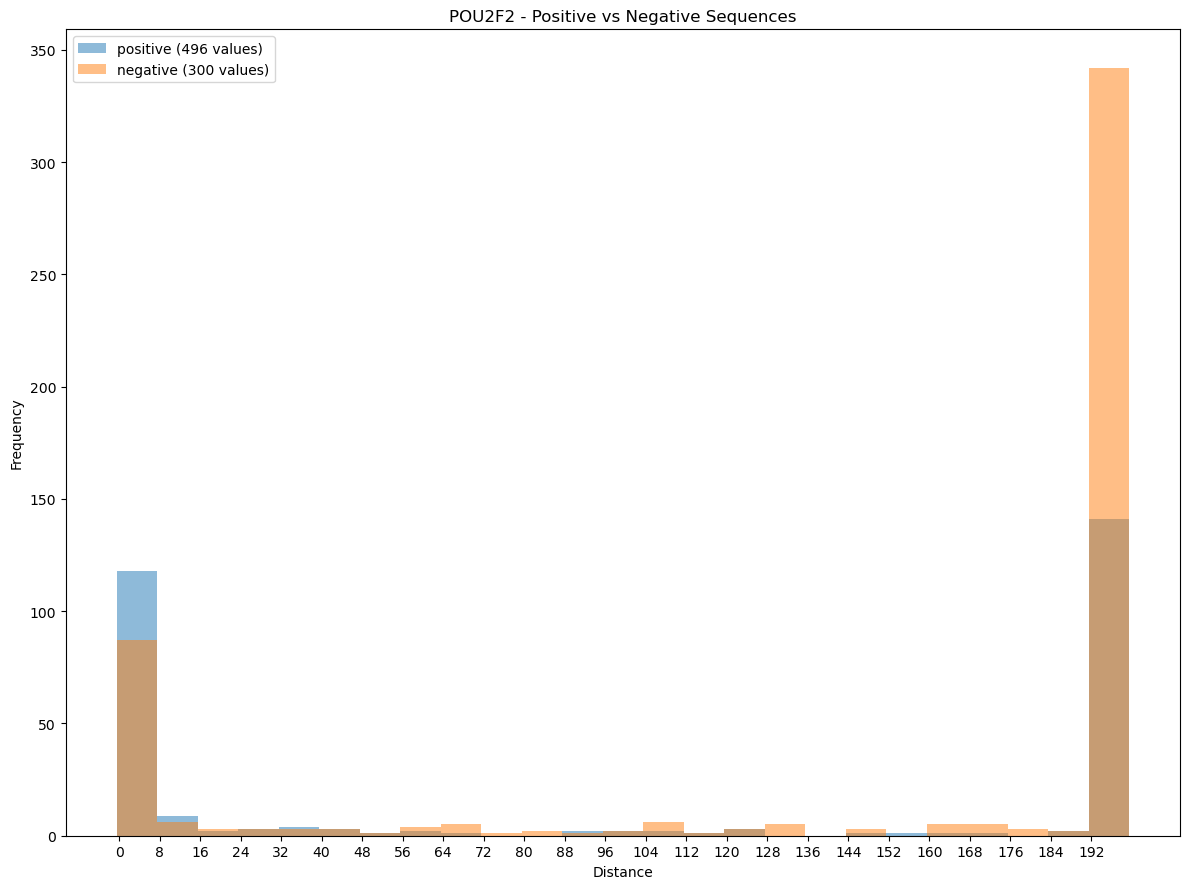

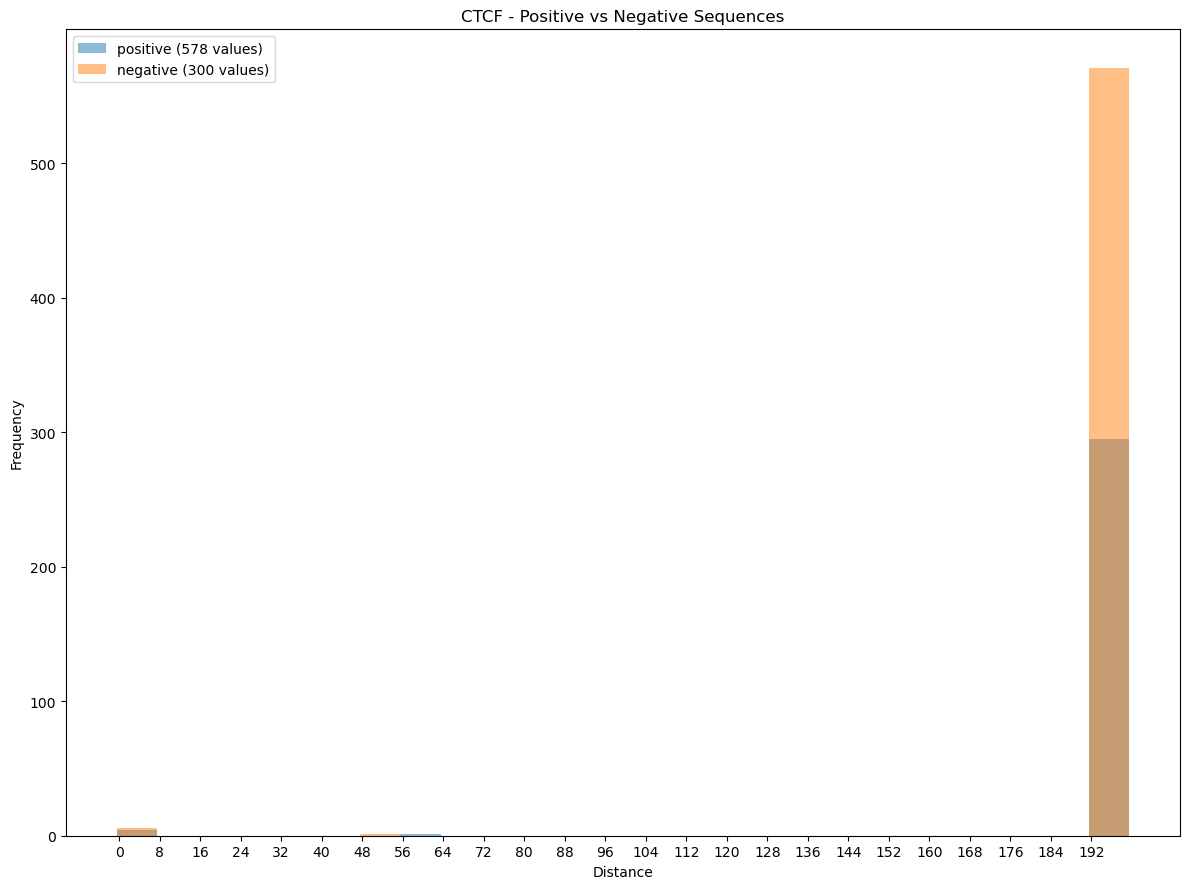

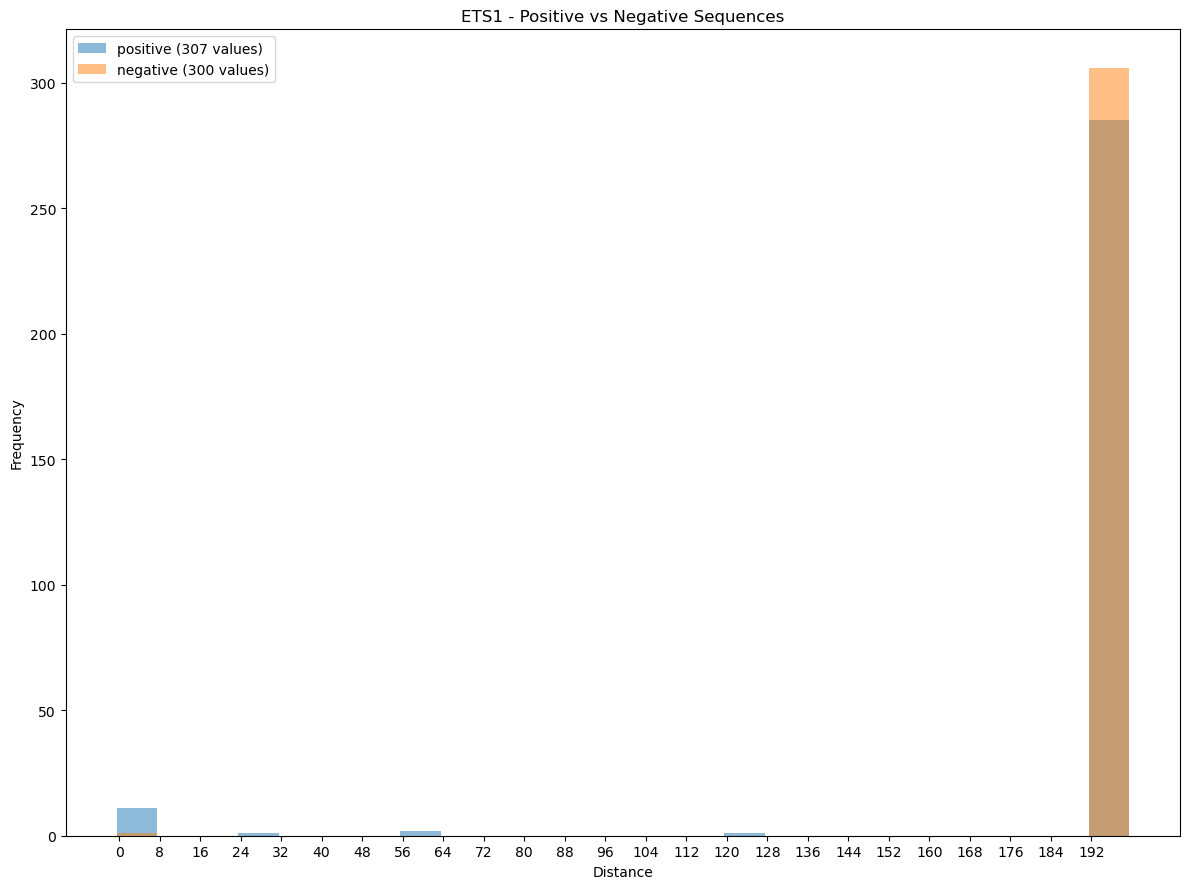

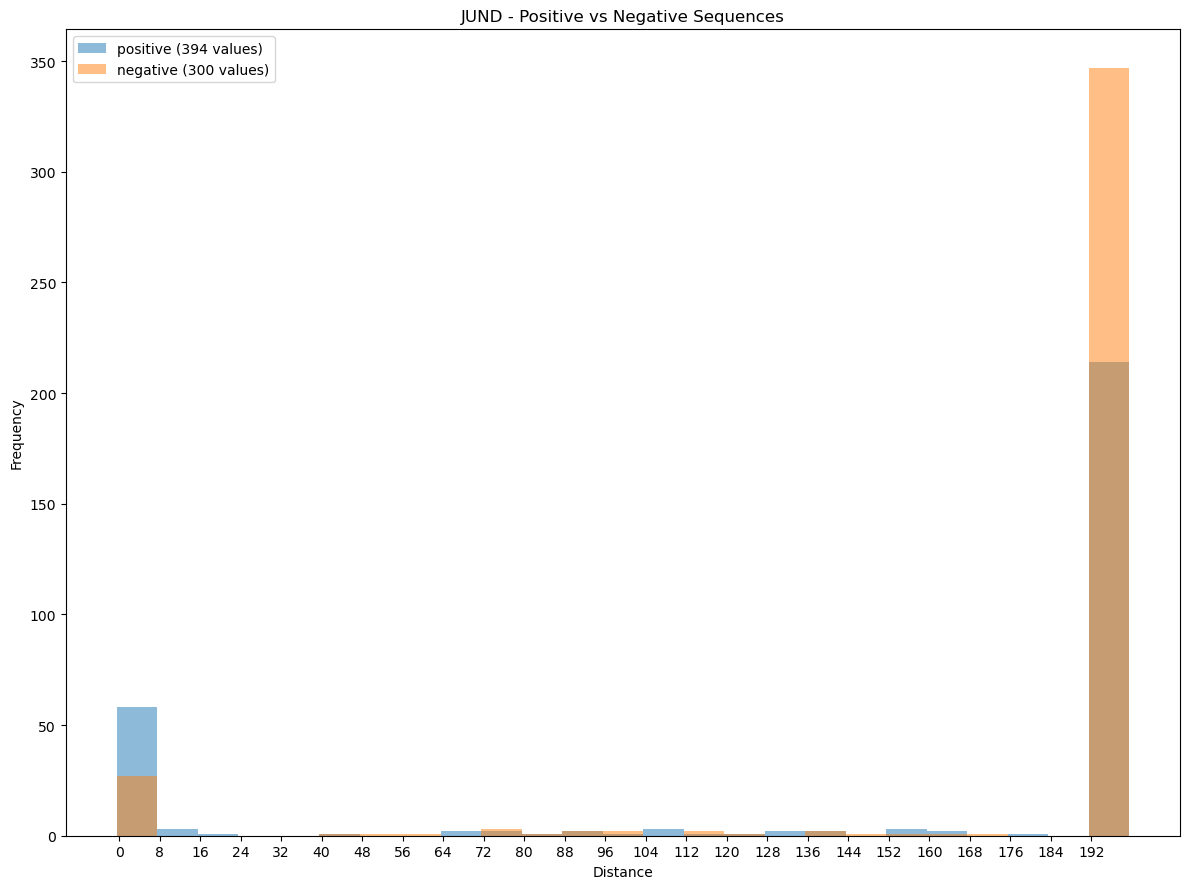

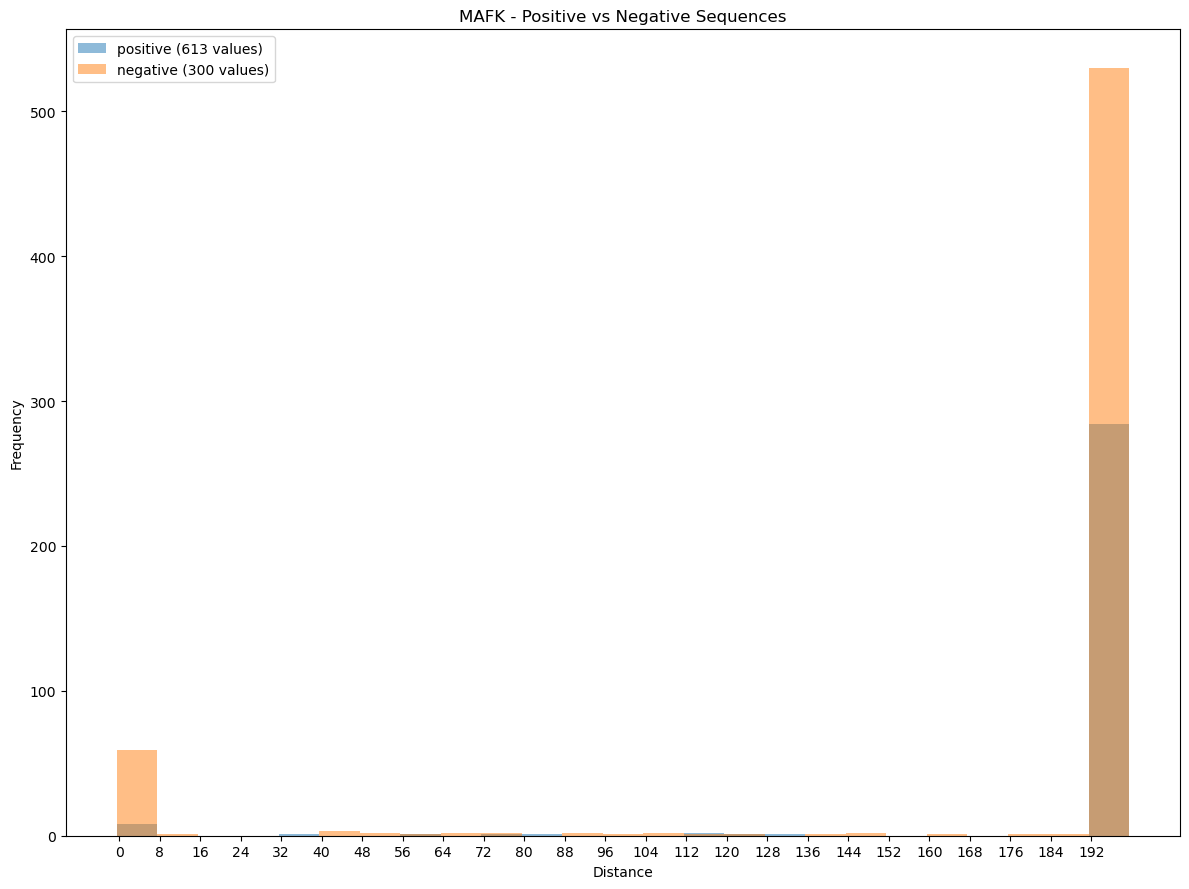

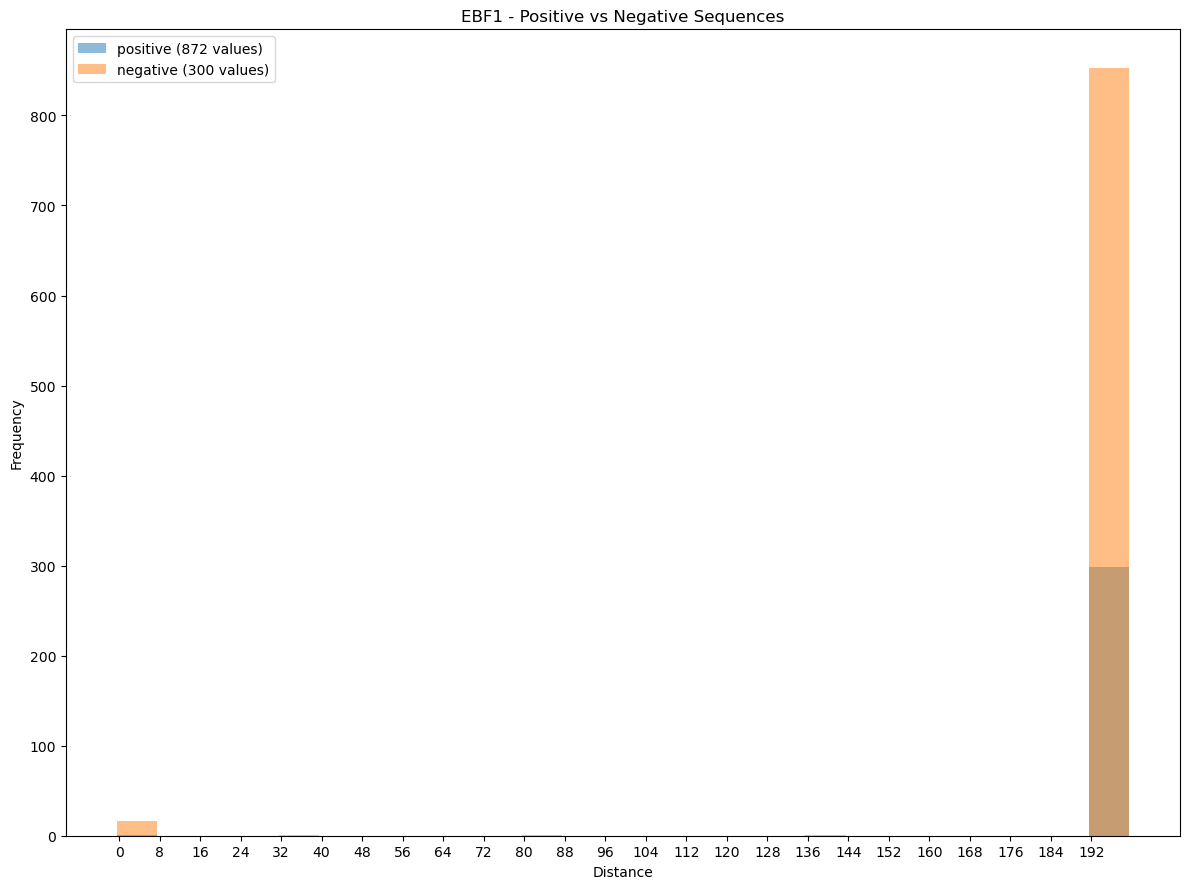

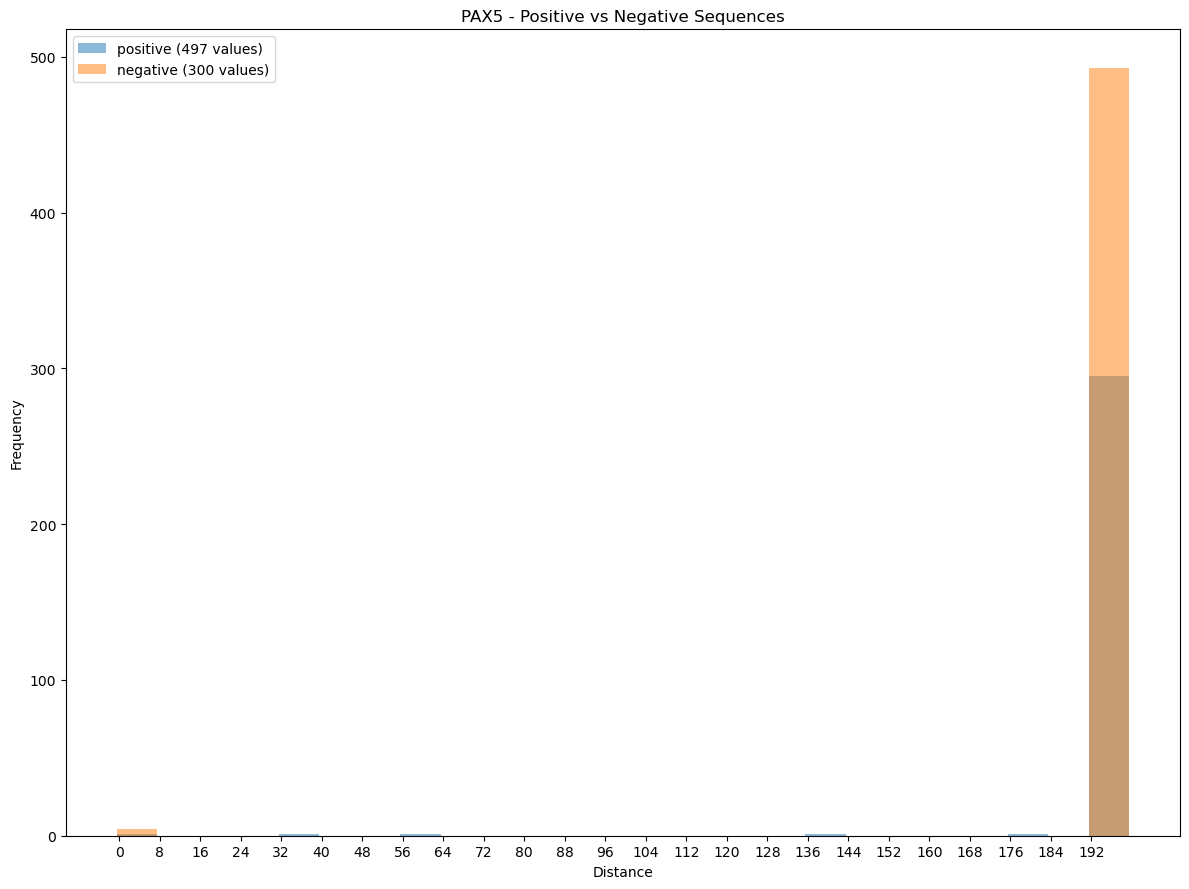

In [77]:
# histogram of the distances of positive label sequences vs negative label sequences
for tf in selected_tfs:
    positive_distances = []
    negative_distances = []
    for distance, label in distance_dict[tf]:
        if label == 1:
            positive_distances.append(distance)
        elif label == 0:
            negative_distances.append(distance)

    # Calculate the range of values and determine bin edges
    value_range = 201
    bin_edges = range(0, value_range, value_range // 25)

    # Create a subplot
    fig, ax = plt.subplots(figsize=(12, 9))

    # Create histograms for positive and negative distances on the same axes
    neg_hist, neg_edges, _ = ax.hist(negative_distances, bins=bin_edges, alpha=0.5, label='negative')
    pos_hist, pos_edges, _ = ax.hist(positive_distances, bins=bin_edges, alpha=0.5, label='positive')

    # Calculate total count of positive and negative data values
    total_pos = int(sum(pos_hist))
    total_neg = int(sum(neg_hist))

    # Add legend with total count annotations
    ax.legend([f'positive ({total_pos} values)', f'negative ({total_neg} values)'])

    ax.set_title(f'{tf} - Positive vs Negative Sequences')
    ax.set_xlabel('Distance')
    ax.set_ylabel('Frequency')

    # Center-align xticks
    ax.set_xticks([edge + 0.5 for edge in bin_edges[:-1]])
    ax.set_xticklabels([str(int(edge)) for edge in bin_edges[:-1]])

    plt.tight_layout()
    plt.savefig(f'/project2/xinhe/waqaas/website/DNA-breathing/figs/phase4_new/strong_motif_distances/{tf}_positive_vs_negative_sequences.png')
    plt.show()

In [78]:
# set 200 as a distance threshold, and perform fisher exact test
threshold = 200

# use a dataframe to store the odds ratio and p-value
odds_ratio_df = pd.DataFrame(index=selected_tfs, columns=['Odds Ratio', 'P-value'])

for tf in selected_tfs:
    positive_distances = []
    negative_distances = []
    for distance, label in distance_dict[tf]:
        if label == 1:
            positive_distances.append(distance)
        elif label == 0:
            negative_distances.append(distance)

    # Perform Fisher's exact test
    contingency_table = [[sum([1 for distance in positive_distances if distance < threshold]), sum([1 for distance in positive_distances if distance >= threshold])],
                         [sum([1 for distance in negative_distances if distance < threshold]), sum([1 for distance in negative_distances if distance >= threshold])]]

    odds_ratio, p_value = fisher_exact(contingency_table)
    odds_ratio_df.at[tf, 'Odds Ratio'] = odds_ratio
    odds_ratio_df.at[tf, 'P-value'] = p_value

In [79]:
# display the df as markdown
print(odds_ratio_df.to_markdown())

|        |   Odds Ratio |     P-value |
|:-------|-------------:|------------:|
| POU2F2 |    0.397727  | 1.1197e-09  |
| CTCF   |    0.723292  | 0.555995    |
| ETS1   |    0.0620915 | 0.00020281  |
| JUND   |    0.353421  | 1.26816e-07 |
| MAFK   |    2.77972   | 0.000104605 |
| EBF1   |    6.66002   | 0.0361246   |
| PAX5   |    0.599593  | 0.514877    |
